In [1]:
import json
import pandas as pd
from numba import njit, prange
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from pandas.api.types import CategoricalDtype
from scipy.optimize import linprog
from scipy.stats import ttest_ind, mannwhitneyu, levene, t
from typing import List, Dict, Optional, Tuple
from zoneinfo import ZoneInfo
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 12  # Minimum font size

## Functions

In [24]:
def interpolate_variable_series(orig_times, orig_values, new_times, method='linear'):
    """
    Interpolates a 1D array of values given the original timestamps and the new target timestamps.
    Parameters:
      orig_times: array-like of original timestamps (assumed to be sorted, dtype=datetime64[ns])
      orig_values: array-like of original values (numeric)
      new_times: array-like of new timestamps (dtype=datetime64[ns])
      method: either 'cosine' (for a smooth, sinusoidal transition) or 'linear'
    Returns:
      A numpy array of interpolated values for new_times.
    """
    # Sort the original times (if not already) and convert to numeric seconds.
    orig_times = np.array(orig_times)
    sort_idx = np.argsort(orig_times)
    orig_times = orig_times[sort_idx]
    orig_values = np.array(orig_values)[sort_idx]

    orig_t_numeric = orig_times.astype('int64') // 10**9
    new_t_numeric = new_times.astype('int64') // 10**9

    # Initialize result array
    res = np.empty(new_t_numeric.shape, dtype=float)

    # Fill values for new times before the first measurement and after the last.
    res[new_t_numeric <= orig_t_numeric[0]] = orig_values[0]
    res[new_t_numeric >= orig_t_numeric[-1]] = orig_values[-1]

    # For times in between, do interpolation.
    mask = (new_t_numeric > orig_t_numeric[0]) & (new_t_numeric < orig_t_numeric[-1])
    if np.any(mask):
        new_valid = new_t_numeric[mask]
        # For each new_valid time, find the index in orig_t_numeric
        idx_upper = np.searchsorted(orig_t_numeric, new_valid, side='right')
        idx_lower = idx_upper - 1

        lower_t = orig_t_numeric[idx_lower]
        upper_t = orig_t_numeric[idx_upper]
        lower_values = orig_values[idx_lower]
        upper_values = orig_values[idx_upper]

        # Compute the time difference (in seconds) between lower and upper timestamps.
        delta = (upper_t - lower_t).astype(float)
        # Compute the fractional difference for each new time, take care to avoid division by zero.
        frac = (new_valid - lower_t) / np.where(delta == 0, 1, delta)

        if method == 'cosine':
            # Use cosine-based weighting for smooth diurnal variables.
            weight = (1 - np.cos(np.pi * frac)) / 2
            interp_val = lower_values + (upper_values - lower_values) * weight
        else:  # linear
            interp_val = lower_values + (upper_values - lower_values) * frac

        res[mask] = interp_val
    return res


def calculate_additional_capacity(
    data: pd.DataFrame,
    source_cols: List[str],            # generation columns in kWh
    capacity_map: Dict[str, float],    # existing capacities in MW
    reduction_targets: List[float] = [0.05, 0.10, 0.25, 0.50],
    storage_gwh: float = 0.0,          # storage energy capacity in GWh
    resid_keyword: Optional[str] = "no growth",
    expand_techs: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Calculate additional MW of capacity needed per tech
    to reduce residual load by given fractions, accounting for storage.

    All energy values are handled in GWh.
    source_cols: columns of generation in kWh (will be converted to GWh).
    Residual Load columns must be in GWh.
    """
    rows = []

    # Make a working copy
    df = data.copy().reset_index(drop=True)

    # 0) If storage is provided, adjust residual loads (in GWh)
    if storage_gwh > 0:
        # find residual column
        resid_cols = [c for c in df.columns if re.search(r'Residual Load', c, re.IGNORECASE)]
        if not resid_cols:
            raise KeyError("No 'Residual Load' column found for storage integration")
        resid_col = resid_cols[0]

        stored = 0.0
        adjusted = []

        for idx, row in df.iterrows():
            resid_gwh = row[resid_col]  # already in GWh

            if resid_gwh < 0:
                # surplus energy available to store
                can_store = min(-resid_gwh, storage_gwh - stored)
                stored += can_store
                resid_adj = resid_gwh + can_store
            else:
                # deficit: discharge if available
                use = min(stored, resid_gwh)
                stored -= use
                resid_adj = resid_gwh - use

            adjusted.append(resid_adj)

        # replace residual time-series with adjusted values
        df[resid_col] = adjusted
    else:
        df = df

    # Determine if multi-scenario based on source_cols naming
    is_multi = all(re.match(r"RCP\d+_[0-9]_[A-Za-z]+", c) for c in source_cols)

    # Build mapping of scenario -> {tech: column}
    if is_multi:
        tech_by_scenario: Dict[str, Dict[str,str]] = {}
        for col in source_cols:
            m = re.match(r"(RCP\d+_[0-9])_(\w+)", col)
            scenario, tech = m.groups()
            tech_by_scenario.setdefault(scenario, {})[tech.lower()] = col
    else:
        tech_by_scenario = {
            "": {re.sub(r"\s+EDP$", "", col, flags=re.IGNORECASE).lower(): col
                  for col in source_cols}
        }

    for scenario, tech_cols in tech_by_scenario.items():
        # find residual column
        pattern_parts = [r"Residual Load"]
        if resid_keyword:
            pattern_parts.append(re.escape(resid_keyword))
        regex = re.compile(".*".join(pattern_parts), re.IGNORECASE)

        matches = [c for c in df.columns if regex.search(c)]
        if matches:
            resid_col = matches[0]
        else:
            fallback = [c for c in df.columns if re.search(r"Residual Load", c, re.IGNORECASE)]
            if not fallback:
                raise KeyError(f"No residual-load column matching keyword and no generic 'Residual Load' found")
            resid_col = fallback[0]

        # total unmet deficit after storage, in GWh
        total_deficit = df[resid_col].clip(lower=0).sum()

        filtered = {tech: col for tech, col in tech_cols.items()
                    if expand_techs is None or tech in expand_techs}
        if not filtered:
            continue

        # compute GWh generated per MW capacity for each tech
        gen_per_mw = {}
        for tech, gen_col in filtered.items():
            # convert generation from kWh to GWh
            total_gen_gwh = df[gen_col].sum() / 1e6
            cap_mw = capacity_map.get(tech)
            if cap_mw is None or total_gen_gwh <= 0:
                raise ValueError(f"Invalid data for tech '{tech}'")
            gen_per_mw[tech] = total_gen_gwh / cap_mw

        share_denom = sum(capacity_map[t] for t in filtered)

        for frac in reduction_targets:
            needed_gwh = frac * total_deficit
            for tech in filtered:
                alloc_gwh = (needed_gwh if len(filtered) == 1
                             else needed_gwh * (capacity_map[tech] / share_denom))
                # additional MW = allocated energy (GWh) / (GWh per MW) => MW
                add_mw = alloc_gwh / gen_per_mw[tech]
                rows.append({
                    "scenario": scenario.replace("_", "."),
                    "technology": tech,
                    "reduction": f"{int(frac*100)}%",
                    "additional_capacity_mw": add_mw
                })

    return pd.DataFrame(rows)


def calculate_additional_capacity_optimized_mix(
    data: pd.DataFrame,
    source_cols: List[str],            # generation columns in kWh
    capacity_map: Dict[str, float],    # existing capacities in MW
    reduction_targets: List[float] = [0.05, 0.10, 0.25, 0.50],
    storage_gwh: float = 0.0,          # storage energy capacity in GWh
    resid_keyword: Optional[str] = "no growth",
    expand_techs: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Calculate additional MW of capacity needed per tech
    and print the optimal mix (percent distribution + MW) for each reduction target.

    All energy values are handled in GWh.
    source_cols: columns of generation in kWh (will be converted to GWh).
    Residual Load columns must be in GWh.
    """
    def optimal_mix(df, tech_cols, capacity_map, resid_col, budget_mw):
        """
        Given a total MW budget, find the mix across techs that maximizes
        residual-load reduction over the time series.
        """
        # build per-MW profile matrix (GWh/MW each timestep)
        T = len(df)
        techs = list(tech_cols.keys())
        G = np.zeros((T, len(techs)))
        for j, tech in enumerate(techs):
            G[:, j] = df[tech_cols[tech]].values / 1e6 / capacity_map[tech]

        # only consider deficit hours
        Rpos = np.maximum(df[resid_col].values, 0.0)

        # objective: maximize sum_t sum_j x_j * G[t,j] * indicator(deficit)
        # => linprog minimize c^T x with c = -G.T @ Rpos
        c = -G.T.dot(Rpos)

        A_eq = np.ones((1, len(techs)))
        b_eq = np.array([budget_mw])
        bounds = [(0, None)] * len(techs)

        res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
        if not res.success:
            raise RuntimeError("Optimal mix failed: " + res.message)
        return {tech: res.x[j] for j, tech in enumerate(techs)}

    rows = []
    df = data.copy().reset_index(drop=True)

    # 0) storage integration
    if storage_gwh > 0:
        resid_cols = [c for c in df.columns if re.search(r'Residual Load', c, re.IGNORECASE)]
        if not resid_cols:
            raise KeyError("No 'Residual Load' column found for storage integration")
        resid_col0 = resid_cols[0]
        stored = 0.0
        adjusted = []
        for _, row in df.iterrows():
            resid_gwh = row[resid_col0]
            if resid_gwh < 0:
                can_store = min(-resid_gwh, storage_gwh - stored)
                stored += can_store
                resid_adj = resid_gwh + can_store
            else:
                use = min(stored, resid_gwh)
                stored -= use
                resid_adj = resid_gwh - use
            adjusted.append(resid_adj)
        df[resid_col0] = adjusted

    is_multi = all(re.match(r"RCP\d+_[0-9]_[A-Za-z]+", c) for c in source_cols)
    if is_multi:
        tech_by_scenario = {}
        for col in source_cols:
            scen, tech = re.match(r"(RCP\d+_[0-9])_(\w+)", col).groups()
            tech_by_scenario.setdefault(scen, {})[tech.lower()] = col
    else:
        tech_by_scenario = {"": {re.sub(r"\s+EDP$", "", c, flags=re.IGNORECASE).lower(): c
                                    for c in source_cols}}

    for scenario, tech_cols in tech_by_scenario.items():
        # choose residual-load column
        pattern = ".*".join([r"Residual Load", re.escape(resid_keyword)])
        regex = re.compile(pattern, re.IGNORECASE)
        matches = [c for c in df.columns if regex.search(c)]
        resid_col = matches[0] if matches else [c for c in df.columns
                                                 if re.search(r"Residual Load", c, re.IGNORECASE)][0]

        total_deficit = df[resid_col].clip(lower=0).sum()
        filtered = {t: col for t, col in tech_cols.items()
                    if expand_techs is None or t in expand_techs}
        if not filtered:
            continue

        # compute generation per MW (GWh/MW)
        gen_per_mw = {}
        for tech, gen_col in filtered.items():
            total_gen = df[gen_col].sum() / 1e6
            cap = capacity_map.get(tech)
            if cap is None or total_gen <= 0:
                raise ValueError(f"Invalid data for tech '{tech}'")
            gen_per_mw[tech] = total_gen / cap

        for frac in reduction_targets:
            needed_gwh = frac * total_deficit
            # naive total MW budget based on average yield
            avg_yield = sum(gen_per_mw.values()) / len(gen_per_mw)
            budget_mw = needed_gwh / avg_yield

            # optimal mix under this budget
            mix = optimal_mix(df, filtered, capacity_map, resid_col, budget_mw)
            total_mw = sum(mix.values())
            dist_pct = {tech: mw / total_mw * 100 for tech, mw in mix.items()}

            # print summary
            print(f"Scenario {scenario.replace('_','.') or 'base'} | Reduction {int(frac*100)}%:")
            for tech in mix:
                print(f"  - {tech}: {mix[tech]:.1f} MW ({dist_pct[tech]:.1f}%)")

            # also append to rows for backward compatibility
            for tech in filtered:
                rows.append({
                    "scenario": scenario.replace("_","."),
                    "technology": tech,
                    "reduction": f"{int(frac*100)}%",
                    "additional_capacity_mw": mix.get(tech, 0.0)
                })

    return pd.DataFrame(rows)


def optimize_investment_mix(
    data: pd.DataFrame,
    source_cols: List[str],
    capacity_map: Dict[str, float],
    initial_investment_eur: float = 1e9,
    exchange_rate: float = 1 / 1.10,
    cost_usd_per_unit: Optional[Dict[str, float]] = None,
    resid_keyword: Optional[str] = None,
    delta_mw: float = 1.0,
    delta_batt_gwh: float = 0.1,
    max_steps: int = 10_000,
) -> Tuple[Dict[str, float], pd.DataFrame]:
    """
    Find a near‐optimal mix of PV, wind, and battery additions to minimize cumulative residual load.
    All added capacity is assumed installed at t=0. Greedy hill‐climb over unit increments.
    
    Returns:
      additions: dict with keys 'photovoltaics_mw', 'wind_mw', 'battery_gwh'
      results: DataFrame comparing baseline, optimized, and single‐tech scenarios
    """
    # 1) Set up costs in EUR
    if cost_usd_per_unit is None:
        cost_usd_per_unit = {
            "photovoltaics": 600e3,
            "wind":        1_915e3,
            "battery":     175e6,
        }
    costs_eur = {tech: usd * exchange_rate for tech, usd in cost_usd_per_unit.items()}

    # 2) Identify the residual‐load column
    df = data.copy().reset_index(drop=True)
    if "Residual Load (GWh) EDP" in df.columns:
        resid_col = "Residual Load (GWh) EDP"
    else:
        if resid_keyword:
            patt = ".*".join([r"Residual Load", re.escape(resid_keyword)])
            regex = re.compile(patt, re.IGNORECASE)
            candidates = [c for c in df.columns if regex.search(c)]
        else:
            candidates = [c for c in df.columns if re.search(r"Residual Load", c, re.IGNORECASE)]
        if not candidates:
            raise KeyError("No 'Residual Load' column found in data")
        resid_col = candidates[0]

    resid = df[resid_col].astype(float).fillna(0.0).values  # assumed in GWh already

    # 3) Pull existing capacities
    existing_pv   = capacity_map.get("photovoltaics")
    existing_wind = capacity_map.get("wind")
    existing_batt = capacity_map.get("battery", 0.0)

    if existing_pv is None or existing_pv <= 0:
        raise ValueError(f"capacity_map['photovoltaics'] must be >0; got {existing_pv}")
    if existing_wind is None or existing_wind <= 0:
        raise ValueError(f"capacity_map['wind'] must be >0; got {existing_wind}")
    if existing_batt < 0:
        raise ValueError(f"capacity_map['battery'] must be ≥0; got {existing_batt}")

    # 4) Locate PV and wind columns by keyword
    col_map = {}
    for col in source_cols:
        lc = col.lower()
        if "photovolta" in lc:
            col_map["photovoltaics"] = col
        elif "wind" in lc:
            col_map["wind"] = col
    for tech in ("photovoltaics", "wind"):
        if tech not in col_map:
            raise KeyError(f"Could not find a '{tech}' column in source_cols")

    # 5) Build per‐unit (per-MW) generation profiles in GWh
    per_unit: Dict[str, np.ndarray] = {}
    for tech in ("photovoltaics", "wind"):
        raw_kwh = df[col_map[tech]].astype(float).values
        raw_gwh = raw_kwh / 1e6
        per_unit[tech] = raw_gwh / capacity_map[tech]

    # 6) Battery simulation helper (SOC starts at 0)
    def simulate_storage(profile: np.ndarray, cap: float) -> np.ndarray:
        soc = 0.0
        out = np.empty_like(profile)
        for i, r in enumerate(profile):
            if r < 0:  # surplus → charge
                charge = min(-r, cap - soc)
                soc += charge
                out[i] = r + charge
            else:      # deficit → discharge
                discharge = min(soc, r)
                soc -= discharge
                out[i] = r - discharge
        return out

    # 7) Compute total residual deficit given additions
    def total_deficit(pv_add: float, wind_add: float, batt_cap: float) -> float:
        r = resid.copy()
        if pv_add:
            r -= per_unit["photovoltaics"] * pv_add
        if wind_add:
            r -= per_unit["wind"] * wind_add
        if batt_cap > 0:
            r = simulate_storage(r, batt_cap)
        return float(np.sum(np.clip(r, 0.0, None)))

    # 8) Baseline with existing battery only
    initial_deficit = total_deficit(0.0, 0.0, existing_batt)

    # 9) Greedy hill climb
    budget = initial_investment_eur
    added  = {"photovoltaics": 0.0, "wind": 0.0, "battery": 0.0}
    current_def = initial_deficit

    for _ in range(max_steps):
        # compute marginal savings per € for each technology
        rates: Dict[str, float] = {}

        # PV
        cost_pv = costs_eur["photovoltaics"] * delta_mw
        if budget >= cost_pv:
            d = total_deficit(added["photovoltaics"] + delta_mw,
                              added["wind"],
                              existing_batt + added["battery"])
            rates["photovoltaics"] = (current_def - d) / cost_pv

        # Wind
        cost_w = costs_eur["wind"] * delta_mw
        if budget >= cost_w:
            d = total_deficit(added["photovoltaics"],
                              added["wind"] + delta_mw,
                              existing_batt + added["battery"])
            rates["wind"] = (current_def - d) / cost_w

        # Battery
        cost_b = costs_eur["battery"] * delta_batt_gwh
        if budget >= cost_b:
            d = total_deficit(added["photovoltaics"],
                              added["wind"],
                              existing_batt + added["battery"] + delta_batt_gwh)
            rates["battery"] = (current_def - d) / cost_b

        if not rates:
            break

        best = max(rates, key=rates.get)
        if rates[best] <= 0:
            break  # no further positive improvement

        # invest in the best tech
        if best in ("photovoltaics", "wind"):
            added[best] += delta_mw
            spend = costs_eur[best] * delta_mw
        else:
            added["battery"] += delta_batt_gwh
            spend = costs_eur["battery"] * delta_batt_gwh

        budget     -= spend
        current_def = total_deficit(added["photovoltaics"],
                                    added["wind"],
                                    existing_batt + added["battery"])

    # 10) Build a comparison table
    scenarios = []
    # baseline
    scenarios.append(("baseline",   0.0,                   0.0,                  0.0,                   initial_deficit))
    # optimized
    def_opt = total_deficit(added["photovoltaics"],
                            added["wind"],
                            existing_batt + added["battery"])
    scenarios.append(("optimized", added["photovoltaics"], added["wind"],     added["battery"],      def_opt))
    # pv only
    pv_only_cap = initial_investment_eur / costs_eur["photovoltaics"]
    d_pv_only = total_deficit(pv_only_cap, 0.0, existing_batt)
    scenarios.append(("pv_only",   pv_only_cap,            0.0,                  0.0,                   d_pv_only))
    # wind only
    w_only_cap = initial_investment_eur / costs_eur["wind"]
    d_w_only = total_deficit(0.0, w_only_cap, existing_batt)
    scenarios.append(("wind_only", 0.0,                   w_only_cap,           0.0,                   d_w_only))
    # battery only
    b_only_cap = initial_investment_eur / costs_eur["battery"]
    d_b_only = total_deficit(0.0, 0.0, existing_batt + b_only_cap)
    scenarios.append(("battery_only", 0.0,                 0.0,                  b_only_cap,            d_b_only))

    results = pd.DataFrame(
        scenarios,
        columns=["scenario", "pv_mw", "wind_mw", "battery_gwh", "residual_deficit_gwh"],
    )
    results["savings_gwh"] = initial_deficit - results["residual_deficit_gwh"]

    additions = {
        "photovoltaics_mw": added["photovoltaics"],
        "wind_mw":          added["wind"],
        "battery_gwh":      added["battery"],
    }
    return additions, results


def hourly_extreme_tests(
    df,
    time_col: str = 'LocalTime',
    temp_col: str = 'avg_t2m',
    vars_to_test: tuple = ('Residual Load (GWh) EDP', 'Total Con (GWh)'),
    freq: str = 'H',
    high_q: float = 0.95,
    low_q: float = 0.05,
    ci_alpha: float = 0.05
) -> pd.DataFrame:
    """
    Aggregates to hourly, flags extremes, and for each var & extreme-type returns:
      - mean_extreme ± 95% CI
      - mean_normal  ± 95% CI
      - mean_diff    ± 95% CI
      - p-values: t-test, Mann-Whitney U, Levene’s test
    """
    # 1. Resample hourly
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.set_index(time_col)
    cols = list(vars_to_test) + [temp_col]
    hourly = df[cols].resample(freq).mean().dropna()

    # 2. Thresholds & masks
    high_thr = hourly[temp_col].quantile(high_q)
    low_thr  = hourly[temp_col].quantile(low_q)
    masks = {
        'Baseline':  (hourly[temp_col] > low_thr) & (hourly[temp_col] < high_thr),
        'Any-extreme':  (hourly[temp_col] >= high_thr) | (hourly[temp_col] <= low_thr),
        'High-extreme': hourly[temp_col] >= high_thr,
        'Low-extreme':  hourly[temp_col] <= low_thr
    }

    results = []
    for mask_name, mask in masks.items():
        for var in vars_to_test:
            x = hourly.loc[mask, var].dropna()
            y = hourly.loc[~mask, var].dropna()
            n1, n2 = len(x), len(y)
            m1, m2 = x.mean(),      y.mean()
            v1, v2 = x.var(ddof=1), y.var(ddof=1)

            # Welch’s t-test
            _, p_t = ttest_ind(x, y, equal_var=False, nan_policy='omit')
            # Mann–Whitney U
            _, p_u = mannwhitneyu(x, y, alternative='two-sided')
            # Levene’s test for equal variances
            _, p_var = levene(x, y)

            # --- 95% CI for each mean ---
            df1, df2 = n1-1, n2-1
            se1, se2 = np.sqrt(v1/n1), np.sqrt(v2/n2)
            t1 = t.ppf(1 - ci_alpha/2, df1) if df1>0 else np.nan
            t2 = t.ppf(1 - ci_alpha/2, df2) if df2>0 else np.nan
            ci1_low, ci1_high = m1 - t1*se1, m1 + t1*se1
            ci2_low, ci2_high = m2 - t2*se2, m2 + t2*se2

            # --- 95% CI for difference of means (extreme - normal) ---
            se_diff = np.sqrt(v1/n1 + v2/n2)
            # Welch–Satterthwaite degrees of freedom
            df_w = (v1/n1 + v2/n2)**2 / ((v1**2)/(n1**2*(n1-1)) + (v2**2)/(n2**2*(n2-1)))
            t_diff = t.ppf(1 - ci_alpha/2, df_w)
            diff = m1 - m2
            ci_diff_low, ci_diff_high = diff - t_diff*se_diff, diff + t_diff*se_diff

            results.append({
                'variable':         var,
                'extreme_type':     mask_name,
                'mean_extreme':     m1,
                'ci_extreme_low':   ci1_low,
                'ci_extreme_high':  ci1_high,
                'mean_normal':      m2,
                'ci_normal_low':    ci2_low,
                'ci_normal_high':   ci2_high,
                'mean_diff':        diff,
                'ci_diff_low':      ci_diff_low,
                'ci_diff_high':     ci_diff_high,
                't_pvalue':         p_t,
                'mw_pvalue':        p_u,
                'var_pvalue':       p_var
            })

    return pd.DataFrame(results).set_index(['variable', 'extreme_type'])


def compute_vre_variability(df, datetime_col, source_cols, windows=None):
    """
    Computes variability of energy sources (in kWh) over different time resolutions,
    expressing the coefficient of variation (CV) as a function of installed capacity.

    Parameters:
    - df: pandas DataFrame with time series data in kWh
    - datetime_col: name of the datetime column (e.g., 'LocalTime')
    - source_cols: list of energy source columns
    - windows: dict of label:resample_freq (optional)

    Returns:
    - DataFrame with combined 'STD (CV)' format (STD in GWh, CV relative to capacity)
    """
    # Capacity reference in MW
    capacity_map = {
        'hydro': 5220,
        'photovoltaics': 539,
        'wind': 1198
    }

    if windows is None:
        windows = {
            '15min': '15min',
            '1h': '1h',
            '4h': '4h',
            '8h': '8h',
            '24h': '1D',
            '48h': '2D',
            '7d': '7D',
            '30d': '30D',
            '1y': '365D',
        }

    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.set_index(datetime_col)

    results = {}

    for label, freq in windows.items():
        results[label] = {}
        for source in source_cols:
            resampled = df[source].resample(freq).sum()
            resampled_gwh = resampled / 1_000_000

            std = resampled_gwh.std()

            # Match installed capacity based on name
            source_lower = source.lower()
            matched_capacity = None
            for key in capacity_map:
                if key in source_lower:
                    matched_capacity = capacity_map[key]
                    break

            if matched_capacity is None:
                raise ValueError(f"Could not determine installed capacity for column '{source}'")

            # Compute average period duration
            if len(resampled.index) > 1:
                period_hours = (resampled.index[1] - resampled.index[0]).total_seconds() / 3600
            else:
                period_hours = pd.Timedelta(freq).total_seconds() / 3600

            expected_max_gwh = (matched_capacity * period_hours) / 1000

            cv = std / expected_max_gwh if expected_max_gwh != 0 else float('nan')

            results[label][source] = f"{std:.2f} ({cv:.2f})"

    return pd.DataFrame(results).T


def storing_energy_limited(df: pd.DataFrame, storage_capacity_gwh: float) -> pd.DataFrame:
    """
    Simulate lossless charge/discharge of a fixed-capacity storage
    over arbitrary intervals, plus linear depreciation,
    and track detailed battery usage & import metrics.

    Inputs:
      - df must contain:
         * 'LocalTime': timestamps (any freq; will diff to get Δt)
         * 'Residual Load (GWh) EDP': signed energy surplus(+)/deficit(–) per interval, in GWh
         * 'Portugal Price (€/MW)': price quoted as €/MW of power

      - storage_capacity_gwh: total capacity in GWh

    Outputs: original df + these new columns:
      * Stored Energy (GWh)
      * Charge (GWh)
      * Discharge (GWh)
      * Raw Import (GWh)            – positive part of the raw residual load
      * Opt Import (GWh)            – positive part of the optimized residual load
      * Battery Throughput (GWh)    – charge + discharge each interval
      * Residual Load (GWh) EDP Optimized
      * Optimized Cost (€)
      * Storage Depreciation (€)
      * Total Cost (€)
    """
    df = df.copy().reset_index(drop=True)
    df['LocalTime'] = pd.to_datetime(df['LocalTime'])

    # 1) Δt in hours; replace any zero/negative with the overall mean Δt
    df['Interval_h'] = df['LocalTime'].diff().dt.total_seconds().div(3600)
    mean_dt = df['Interval_h'].mean()
    df['Interval_h'] = df['Interval_h'].mask(df['Interval_h'] <= 0, mean_dt)

    # Depreciation rate: 227 €/MWh of capacity → € per interval-hour
    depr_per_h = (storage_capacity_gwh * 1e3 * 227.0) / (5 * 365 * 24)

    # initialize new columns
    for col in [
        'Stored Energy (GWh)',
        'Charge (GWh)',
        'Discharge (GWh)',
        'Raw Import (GWh)',
        'Opt Import (GWh)',
        'Battery Throughput (GWh)',
        'Residual Load (GWh) EDP Optimized',
        'Optimized Cost (€)',
        'Storage Depreciation (€)',
        'Total Cost (€)'
    ]:
        df[col] = 0.0

    stored = 0.0
    for i, row in df.iterrows():
        load    = row['Residual Load (GWh) EDP']
        price_mwh= row['Portugal Price (€/MW)']
        Δt      = row['Interval_h']

        # reset per‐interval trackers
        charge   = 0.0
        discharge= 0.0

        if load < 0:
            # surplus: charge up to capacity, export the rest
            surplus  = -load
            charge   = min(surplus, storage_capacity_gwh - stored)
            stored  += charge
            to_sell  = surplus - charge

            rl_opt = -to_sell
            cost   = -to_sell * 1_000 * price_mwh

        elif load > 0:
            # deficit: discharge what you can, then import the rest
            discharge = min(stored, load)
            stored   -= discharge
            to_buy    = load - discharge

            rl_opt = to_buy
            cost   =    to_buy * 1_000 * price_mwh

        else:
            rl_opt = 0.0
            cost   = 0.0

        depr       = depr_per_h * Δt
        total_cost = cost + depr

        # write back
        df.at[i, 'Stored Energy (GWh)']               = stored
        df.at[i, 'Charge (GWh)']                      = charge
        df.at[i, 'Discharge (GWh)']                   = discharge
        df.at[i, 'Raw Import (GWh)']                  = max(load, 0.0)
        df.at[i, 'Residual Load (GWh) EDP Optimized'] = rl_opt
        df.at[i, 'Opt Import (GWh)']                  = max(rl_opt, 0.0)
        df.at[i, 'Battery Throughput (GWh)']          = charge + discharge
        df.at[i, 'Optimized Cost (€)']                = cost
        df.at[i, 'Storage Depreciation (€)']           = depr
        df.at[i, 'Total Cost (€)']                    = total_cost

    return df

@njit
def _simulate(loads, prices, capacity, thr):
    n = loads.shape[0]
    stored = 0.0
    total = 0.0
    costs    = np.empty(n, dtype=np.float64)
    soc      = np.empty(n, dtype=np.float64)
    rl_opt   = np.empty(n, dtype=np.float64)  # new: net grid exchange

    for i in range(n):
        ld = loads[i]      # in MWh (negative → surplus)
        pr = prices[i]
        c  = 0.0

        if ld < 0:
            surplus = -ld
            # decide whether to store
            if pr <= thr:
                to_store = min(surplus, capacity - stored)
            else:
                to_store = 0.0
            stored += to_store
            to_sell   = surplus - to_store
            c = -to_sell * pr
            rl_opt[i] = -to_sell   # negative → we feed into grid

        elif ld > 0:
            used  = min(stored, ld)
            stored -= used
            to_buy = ld - used
            c = to_buy * pr
            rl_opt[i] = to_buy     # positive → we draw from grid

        else:
            rl_opt[i] = 0.0

        costs[i] = c
        soc[i]   = stored
        total   += c

    # terminal liquidation
    costs[-1]   -= stored * prices[-1]
    rl_opt[-1]   = 0.0
    soc[-1]      = 0.0
    mean_cost    = total / n - (stored * prices[-1]) / n
    return mean_cost, costs, soc, rl_opt

@njit(parallel=True)
def _sweep_thresholds(loads, prices, capacity, thresholds):
    nt = thresholds.shape[0]
    means = np.empty(nt, dtype=np.float64)
    for j in prange(nt):
        mc, _, _, _ = _simulate(loads, prices, capacity, thresholds[j])
        means[j] = mc
    return means

def storing_energy_limited_w_price_fast(df: pd.DataFrame,
                                        storage_capacity_gwh: float
                                       ) -> pd.DataFrame:
    """
    Simulate lossless charge/discharge of a fixed-capacity storage
    over arbitrary intervals, plus linear depreciation,
    choosing the best single price‐threshold strategy.

    Inputs:
      - df must contain:
         * 'LocalTime'              : timestamps (any freq; we diff to get Δt)
         * 'Residual Load (GWh) EDP': signed energy surplus(+)/deficit(–) per interval, in GWh
         * 'Portugal Price (€/MW)'  : price quoted as €/MW of power

      - storage_capacity_gwh: total capacity in GWh

    Outputs: original df + these columns:
      * Stored Energy (GWh)                 – state-of-charge after each interval
      * Residual Load (GWh) EDP Optimized   – new net load (GWh) after using storage
      * Optimized Cost (€)                  – cost of net import(+)/export(–)
      * Storage Depreciation (€)            – capex depreciation during each Δt
      * Total Cost (€)                      – sum of optimized cost + depreciation
    """
    # copy & prep
    out = df.copy().reset_index(drop=True)
    out['LocalTime'] = pd.to_datetime(out['LocalTime'])

    # extract arrays for Numba
    lt       = out['LocalTime'].values.astype('datetime64[s]')
    years    = out['LocalTime'].dt.year.values
    loads_mwh= out['Residual Load (GWh) EDP'].values * 1_000
    prices   = out['Portugal Price (€/MW)'].values
    capacity = storage_capacity_gwh * 1_000

    # pick best threshold (€/MWh) by sweeping
    thresholds = np.unique(prices.astype(np.int32))
    means      = _sweep_thresholds(loads_mwh, prices, capacity, thresholds)

    # if you have >1 full year, average per‐year instead of one giant mean
    yrs = np.unique(years)
    if yrs.size > 1:
        per = []
        for thr in thresholds:
            mc, costs, soc, rl = _simulate(loads_mwh, prices, capacity, thr)
            yearly = [ costs[years==y].sum() for y in yrs[:-1] ]
            per.append(np.mean(yearly))
        means = np.array(per)

    best_i = int(np.argmin(means))
    best_thr = thresholds[best_i]
    print(f"→ Chosen price threshold = €{best_thr}/MWh")

    # final sim at best threshold
    _, costs, soc_mwh, rl_mwh = _simulate(loads_mwh, prices, capacity, best_thr)

    # put back into DataFrame (all in GWh)
    out['Optimized Cost (€)']                = costs
    out['Stored Energy (GWh)']               = soc_mwh    / 1_000
    out['Residual Load (GWh) EDP Optimized'] = rl_mwh     / 1_000
    out['Raw Import (GWh)'] = np.maximum(loads_mwh, 0) / 1_000
    out['Opt Import (GWh)'] = np.maximum(rl_mwh, 0) / 1_000

    # battery charge/discharge (GWh) as the positive/negative SOC step
    # prepend a zero so diff is length-n
    soc_full = np.concatenate([[0.], soc_mwh])
    delta = np.diff(soc_full)
    out['Charge (GWh)']    = np.maximum(delta, 0) / 1_000
    out['Discharge (GWh)'] = np.maximum(-delta, 0) / 1_000

    out['Battery Throughput (GWh)'] = out['Charge (GWh)'] + out['Discharge (GWh)']

    # depreciation exactly as in the limited function
    # 1) compute Δt in hours
    dt = lt.astype('int64')
    interval_h       = np.empty_like(dt, dtype=float)
    interval_h[1:]   = (dt[1:] - dt[:-1]) / 3600
    interval_h[0]    = np.median(interval_h[1:])
    # 2) same capex spread
    depr_per_h = (storage_capacity_gwh * 1e6 * 227.0) / (5 * 365 * 24)
    out['Storage Depreciation (€)'] = interval_h * depr_per_h

    out['Interval_h'] = interval_h

    # total cost
    out['Total Cost (€)'] = out['Optimized Cost (€)'] + out['Storage Depreciation (€)']

    return out


def plot_storage_results(df: pd.DataFrame):
    """
    Expects df with the columns added above, including:
      - 'Optimized Cost (€)'      : optimized cost per interval
      - 'Cost' or 'Costs'         : raw cost per interval
      - 'Stored Energy (GWh)'
      - 'Raw Import (GWh)'
      - 'Opt Import (GWh)'
      - 'Charge (GWh)'
      - 'Discharge (GWh)'
      - 'Interval_h'
      - 'LocalTime'

    Produces four panels:
      A) Stored Energy over Time
      B) Cumulative Optimized vs Raw Costs (same axis)
      C) Import duration curves (raw vs optimized)
      D) Charge vs Discharge power
    """
    df = df.copy()
    df['LocalTime'] = pd.to_datetime(df['LocalTime'])
    df.sort_values('LocalTime', inplace=True)

    # compute cumulative sums for comparison
    df['CumOptCost'] = df['Optimized Cost (€)'].cumsum()
    raw_cost_col = 'Cost' if 'Cost' in df.columns else 'Costs'
    df['CumRawCost'] = df[raw_cost_col].cumsum()

    locator   = AutoDateLocator()
    formatter = ConciseDateFormatter(locator)

    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    axA, axB, axC, axD = axes.flatten()

    # --- A) Stored Energy over Time ---
    axA.plot(df['LocalTime'], df['Stored Energy (GWh)'], lw=1)
    axA.set_title('Stored Energy over Time')
    axA.set_xlabel('')
    axA.set_ylabel('State of Charge (GWh)')
    axA.xaxis.set_major_locator(locator)
    axA.xaxis.set_major_formatter(formatter)

    # --- B) Cumulative Costs (same axis) ---
    axB.plot(df['LocalTime'], df['CumOptCost'], lw=1.2, label='Optimized Cost (cum.)')
    axB.plot(df['LocalTime'], df['CumRawCost'], lw=1.2, label='Raw Cost (cum.)', linestyle='--')
    axB.set_xlabel('')
    axB.set_ylabel('Cumulative Cost (€)')
    axB.legend(loc='upper left')
    axB.set_title('Cumulative Optimized vs Raw Costs')
    axB.xaxis.set_major_locator(locator)
    axB.xaxis.set_major_formatter(formatter)

    # --- C) Import Duration Curves ---
    raw = df[['Raw Import (GWh)','Interval_h']].copy()
    opt = df[['Opt Import (GWh)','Interval_h']].copy()

    raw = raw.sort_values('Raw Import (GWh)', ascending=False).reset_index(drop=True)
    opt = opt.sort_values('Opt Import (GWh)', ascending=False).reset_index(drop=True)

    raw['Hours'] = raw['Interval_h'].cumsum()
    opt['Hours'] = opt['Interval_h'].cumsum()

    axC.plot(raw['Hours'], raw['Raw Import (GWh)'], lw=1, label='Raw Import')
    axC.plot(opt['Hours'], opt['Opt Import (GWh)'], lw=1, label='Opt Import')
    axC.set_title('Import Duration Curve')
    axC.set_xlabel('Cumulative Hours')
    axC.set_ylabel('Import (GWh)')
    axC.legend()
    axC.grid(True, linestyle='--', alpha=0.3)

    # annotate totals
    total_raw = (raw['Raw Import (GWh)'] * raw['Interval_h']).sum()
    total_opt = (opt['Opt Import (GWh)'] * opt['Interval_h']).sum()
    axC.text(
        0.95, 0.95,
        f"Total Raw: {total_raw:.1f} GWh\nTotal Opt: {total_opt:.1f} GWh",
        ha='right', va='top', transform=axC.transAxes,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
    )

    # --- D) Charge vs Discharge ---
    axD.plot(df['LocalTime'], df['Charge (GWh)'], label='Charge', lw=1)
    axD.plot(df['LocalTime'], df['Discharge (GWh)'], label='Discharge', lw=1)
    axD.set_title('Battery Charge / Discharge per Interval')
    axD.set_xlabel('Time')
    axD.set_ylabel('Energy (GWh)')
    axD.legend()
    axD.xaxis.set_major_locator(locator)
    axD.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.show()

def simulate_energy_bitcoin(
    df: pd.DataFrame,
    storage_capacity_gwh: float,
    equipment_budget: float = 500_000_000,
    rig_cost_per_ths: float = 25.0,
    rig_power_per_ths: float = 0.025,
    avg_transaction_fees_btc: float = 0.05,
    equipment_lifetime_years: float = 2.0,
    storage_depr_years: float = 3.0,
    storage_install_cost_per_kwh: float = 227.0,
    fixed_om_cost_per_mwh: float = 1.0,
    pue: float = 1.15,
    initial_block_reward: float = 50.0,
    block_time_s: float = 600.0,
    interval_minutes: float = 15.0
) -> pd.DataFrame:
    """
    Simulate energy storage + Bitcoin mining, tracking detailed battery metrics.

    Only mine if expected mining revenue exceeds selling surplus energy,
    and always fill storage first when price is below average.

    Inputs (in addition to common df columns):
      - df['LocalTime']               : timestamp
      - df['Residual Load (GWh) EDP'] : signed energy surplus(+)/deficit(–)
      - df['Portugal Price (€/MW)']   : €/MW of power
      - df['avg_bitcoin_price']       : €/BTC

    Outputs: original df + these new columns:
      * Stored Energy (GWh)
      * Charge (GWh)
      * Discharge (GWh)
      * Raw Import (GWh)
      * Opt Import (GWh)
      * Battery Throughput (GWh)
      * Energy Cost (€)
      * Energy Revenue (€)
      * Hours Mined
      * BTC Mined
      * Mining Energy Cost (€)
      * CapEx & O&M Cost (€)
      * Mining Revenue (€)
      * Mining Profit (€)
      * Optimized Cost (€)
      * Total Cost (€)
      * Profit (€)
    """
    # Load Bitcoin Hash Rate Data
    with open('/Users/darcor/PycharmProjects/Setup/Data/hash-rate.json', 'r') as file:
        data = json.load(file)
        hash_rate_df = pd.DataFrame(data['hash-rate'])
        hash_rate_df['x'] = pd.to_datetime(hash_rate_df['x'], unit='ms', utc=True)
        hash_rate_df['y'] = hash_rate_df['y'].astype(float)
        hash_rate_df = hash_rate_df.rename(columns={'x': 'LocalTime', 'y': 'hash_rate'})
        hash_rate_df = hash_rate_df[(hash_rate_df["LocalTime"] > "2023-01-01") & (hash_rate_df["LocalTime"] < "2025-04-01")]
        
        # Set index
        hash_rate_df = hash_rate_df.set_index('LocalTime')

        # Create new 15-min frequency index
        new_index = pd.date_range(start=hash_rate_df.index.min(), end=hash_rate_df.index.max(), freq='15min')

        # Reindex and forward fill
        hash_rates = hash_rate_df.reindex(new_index).ffill()

        # Restore 'LocalTime' as a column
        hash_rates.index.name = 'LocalTime'
        hash_rates = hash_rates.reset_index()
        hash_rates['LocalTime'] = pd.to_datetime(hash_rates['LocalTime']).dt.tz_localize(None)

    # Optionally, delete the original DataFrame
    del hash_rate_df, new_index

    # Bitcoin Prices
    bitcoin_data = pd.read_excel("/Users/darcor/PycharmProjects/Setup/Data/Bitstamp_BTCEUR_1h.xlsx", skiprows=1)
    # Parse date first without localization
    bitcoin_data['date'] = pd.to_datetime(bitcoin_data['date'])

    # Filter only from 2023 onwards
    bitcoin_data = bitcoin_data[bitcoin_data['date'] >= '2023-01-01']

    bitcoin_data = bitcoin_data.drop_duplicates(subset='date')

    # Localize to NY time safely (no ambiguous timestamps after filtering)
    bitcoin_data['date'] = bitcoin_data['date'].dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent='shift_forward')

    # Compute average price and convert to Lisbon time
    bitcoin_data['avg_bitcoin_price'] = round(bitcoin_data[['high', 'low']].mean(axis=1), 2)
    bitcoin_data['LocalTime'] = bitcoin_data['date'].dt.floor('h').dt.tz_convert('Europe/Lisbon')

    # Keep only necessary columns
    bitcoin_data = bitcoin_data[['LocalTime', 'avg_bitcoin_price']]

    bitcoin_data = bitcoin_data.drop_duplicates(subset='LocalTime')

    # Set index
    bitcoin_data = bitcoin_data.set_index('LocalTime')

    # Create new 15-min frequency index
    new_index = pd.date_range(start=bitcoin_data.index.min(), end=bitcoin_data.index.max(), freq='15min')

    # Reindex and forward fill
    bitcoin_prices = bitcoin_data.reindex(new_index).ffill()

    bitcoin_prices.index.name = 'LocalTime'
    bitcoin_prices = bitcoin_prices.reset_index()
    bitcoin_prices['LocalTime'] = pd.to_datetime(bitcoin_prices['LocalTime']).dt.tz_localize(None)
    
    required = {'LocalTime','Residual Load (GWh) EDP','Portugal Price (€/MW)'}
    missing = required - set(df.columns)
    if missing:
        raise KeyError(f"Missing columns: {missing}")

    out = df.copy()
    out['LocalTime'] = pd.to_datetime(out['LocalTime']).dt.tz_localize(None)
    mean_price = out['Portugal Price (€/MW)'].mean()
    out = out.merge(hash_rates, how='left', left_on='LocalTime', right_on='LocalTime')
    out['hash_rate'] = out['hash_rate'].ffill()
    out = out.merge(bitcoin_prices, how='left', left_on='LocalTime', right_on='LocalTime')
    out['avg_bitcoin_price'] = out['avg_bitcoin_price'].ffill()

    # parameters
    your_ths        = equipment_budget / rig_cost_per_ths
    interval_h      = interval_minutes / 60.0
    secs_per_interval = interval_minutes * 60.0

    # Depreciation & Amortization
    storage_install_cost = storage_capacity_gwh * 1e6 * storage_install_cost_per_kwh
    total_inv    = equipment_budget + storage_install_cost
    depr_per_h   = total_inv / (storage_depr_years * 365 * 24)
    amort_per_h  = equipment_budget / (equipment_lifetime_years * 365 * 24)

    # initialize outputs

    cols = [
      'Stored Energy (GWh)','Charge (GWh)','Discharge (GWh)',
      'Raw Import (GWh)','Opt Import (GWh)','Battery Throughput (GWh)',
      'Energy Cost (€)','Energy Revenue (€)', 'Mining Revenue (€)',
      'Hours Mined','BTC Mined','Mining Energy Cost (€)',
      'CapEx & O&M Cost (€)', 'Storage Depreciation (€)',
      'Mining Profit (€)', 'Saved Costs (€)',
      'Profit (€)', 'Real Optimized Cost (€)', 'Total Cost (€)'
    ]
    for c in cols:
        out[c] = 0.0

    # mining timing
    first_block_time = datetime(2009, 1, 3, 18, 15, 5)
    halving = 210_000

    stored = 0.0
    for idx, row in out.iterrows():
        load   = row['Residual Load (GWh) EDP']
        network_ths = row['hash_rate']
        price  = row['Portugal Price (€/MW)']
        btc_px = row['avg_bitcoin_price']

        # reset interval variables
        charge = discharge = raw_import = opt_import = 0.0
        cost_bought = energy_rev = hrs = btc = e_cost = capex = om = mining_rev = mining_prof = saved_costs = 0.0

        # --- surplus handling: first fill storage ---
        if load < 0:
            surplus = -load
            # fill battery when price low
            if price < mean_price and stored < storage_capacity_gwh:
                to_store = min(surplus, storage_capacity_gwh - stored)
                stored  += to_store
                charge   = to_store
                surplus -= to_store

            # decide between mining vs selling
            if surplus > 0:
                # compute mining capacity this interval
                power_kw = your_ths * rig_power_per_ths * pue
                need_mwh = power_kw * interval_h / 1000.0
                need_gwh = need_mwh / 1000.0
                use_gwh  = min(surplus, need_gwh)

                # reward and share
                elapsed = (row['LocalTime'] - first_block_time).total_seconds()
                height  = int(elapsed // block_time_s)
                epoch   = height // halving
                reward  = initial_block_reward/(2**epoch) + avg_transaction_fees_btc
                share   = your_ths / network_ths
                blocks  = secs_per_interval / block_time_s

                # BTC per GWh and revenue
                btc_per_gwh = share * reward * blocks / need_gwh
                rev_mine    = btc_per_gwh * use_gwh * btc_px
                rev_sell    = use_gwh * 1000.0 * price

                # only mine if more profitable than selling
                if rev_mine > rev_sell:
                    use      = use_gwh
                    surplus -= use
                    hrs      = interval_h * (use/need_gwh)
                    btc      = btc_per_gwh * use
                    e_cost   = use * 1000.0 * price
                    capex    = amort_per_h * hrs
                    om       = fixed_om_cost_per_mwh * use * 1000.0
                    mining_rev  = btc * btc_px
                    mining_prof = mining_rev - (e_cost + capex + om)
                else:
                    # sell instead
                    energy_rev += surplus * 1000.0 * price
                    surplus = 0.0

        # --- demand purchase / discharge ---
        if load > 0:
            raw_import = load
            if price < mean_price:
                cost_bought = load * 1000.0 * price
            else:
                orig_cost = load * 1000.0 * price
                discharge = min(stored, load)
                stored   -= discharge
                buy       = load - discharge
                cost_bought   = buy * 1000.0 * price
                saved_costs   = orig_cost - cost_bought

        # compute optimized import
        opt_import = max(0.0, load) - discharge

        # battery throughput and depreciation
        throughput    = charge + discharge
        depreciation  = depr_per_h * interval_h

        # Opt Costs with Mining Revenue + Energy Revenue - Energy Bought
        opt = cost_bought - energy_rev - mining_rev

        # real optimization objective
        real_opt = cost_bought + depreciation + om - mining_rev - energy_rev
        profit = mining_rev + energy_rev - cost_bought - e_cost - capex - om - depreciation

        # finalize metrics
        out.at[idx, 'Stored Energy (GWh)']             = stored
        out.at[idx, 'Charge (GWh)']                    = charge
        out.at[idx, 'Discharge (GWh)']                 = discharge
        out.at[idx, 'Raw Import (GWh)']                = max(load,0.0)
        out.at[idx, 'Opt Import (GWh)']                = opt_import
        out.at[idx, 'Battery Throughput (GWh)']        = throughput
        out.at[idx, 'Energy Cost (€)']                 = cost_bought
        out.at[idx, 'Energy Revenue (€)']              = energy_rev
        out.at[idx, 'Hours Mined']                     = hrs
        out.at[idx, 'BTC Mined']                       = btc
        out.at[idx, 'Mining Revenue (€)']              = mining_rev
        out.at[idx, 'Mining Profit (€)']               = mining_prof
        out.at[idx, 'Mining Energy Cost (€)']          = e_cost
        out.at[idx, 'Storage Depreciation (€)']        = depreciation
        out.at[idx, 'CapEx & O&M Cost (€)']            = capex + om
        out.at[idx, 'Saved Costs (€)']                 = saved_costs
        out.at[idx, 'Optimized Cost (€)']              = opt
        out.at[idx, 'Total Cost (€)']                  = real_opt
        out.at[idx, 'Profit']                          = profit
        out.at[idx, 'Interval_h']                      = interval_h

    return out


In [3]:
reanalysis = pd.read_excel("/Users/darcor/Data/EDP Thesis/Output/Predictions/Reanalysis_15min.xlsx")

In [5]:
def compute_vre_variability(df, datetime_col, source_cols, windows=None):
    """
    Computes variability of energy sources (in kWh) over different time resolutions,
    expressing the coefficient of variation (CV) as a function of installed capacity.

    Parameters:
    - df: pandas DataFrame with time series data in kWh
    - datetime_col: name of the datetime column (e.g., 'LocalTime')
    - source_cols: list of energy source columns
    - windows: dict of label:resample_freq (optional)

    Returns:
    - DataFrame with combined 'STD (CV)' format (STD in GWh, CV relative to capacity)
    """
    # Capacity reference in MW
    capacity_map = {
        'hydro': 5220,
        'photovoltaics': 539,
        'wind': 1198
    }

    if windows is None:
        windows = {
            '15min': '15min',
            '1h': '1h',
            '4h': '4h',
            '8h': '8h',
            '24h': '1D',
            '48h': '2D',
            '7d': '7D',
            '30d': '30D',
            '1y': '365D',
        }

    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.set_index(datetime_col)

    results = {}

    for label, freq in windows.items():
        results[label] = {}
        for source in source_cols:
            # Resample and aggregate
            resampled = df[source].resample(freq).sum()
            # Convert to GWh
            resampled_gwh = resampled / 1_000_000

            # Compute standard deviation and mean
            std_gwh = resampled_gwh.std()
            mean_gwh = resampled_gwh.mean()
            # Compute coefficient of variation: std/mean
            cv = std_gwh / mean_gwh if mean_gwh != 0 else float('nan')

            results[label][source] = f"{std_gwh:.2f} ({cv:.2f})"

    return pd.DataFrame(results).T

### Adding avg interpolated temperature

In [ ]:
import xarray as xr
ds = xr.open_dataset('/Users/darcor/Data/EDP Thesis/Output/Climate Data/era5_portugal_baseline.nc', chunks={'time':365})
ds = ds.mean(dim=[d for d in ds.dims if d!='time'])
if 't2m' in ds:
        ds['t2m'] -= 273.15

df = ds.to_dataframe().reset_index()

temperature_data = df[['time', 't2m']]

del df, ds

temperature_data = temperature_data[temperature_data['time'] > '2020-01-01']

temperature_data.set_index('time', inplace=True)

new_index = pd.date_range(start=temperature_data.index.min(), end=temperature_data.index.max(), freq='15min')

temperature_data_interp = pd.DataFrame(index=new_index)

interpolated = interpolate_variable_series(temperature_data.index.values, temperature_data['t2m'].values,
                                           new_index.values, method='cosine')

del new_index, temperature_data

temperature_data_interp['avg_t2m'] = interpolated

temperature_data_interp.reset_index(inplace=True)
temperature_data_interp.rename(columns={'index': 'time'}, inplace=True)
temperature_data_interp['time'] = pd.to_datetime(temperature_data_interp['time'])
temperature_data_interp['time'] = temperature_data_interp['time'].dt.tz_localize('UTC').dt.tz_convert('Europe/Lisbon')
temperature_data_interp['LocalTime'] = temperature_data_interp['time'].dt.tz_localize(None)

temperature_data_interp = temperature_data_interp[['LocalTime', 'avg_t2m']]

reanalysis = reanalysis.merge(temperature_data_interp, how='left', on='LocalTime')
del temperature_data_interp, interpolated

ValueError: You are trying to merge on datetime64[ns, Europe/Lisbon] and datetime64[ns] columns for key 'LocalTime'. If you wish to proceed you should use pd.concat

### Adding avg bitcoin price

In [6]:
bitcoin_data = pd.read_excel("/Users/darcor/PycharmProjects/Setup/Data/Bitstamp_BTCEUR_1h.xlsx", skiprows=1)

# Parse date first without localization
bitcoin_data['date'] = pd.to_datetime(bitcoin_data['date'])

# Filter only from 2023 onwards
bitcoin_data = bitcoin_data[bitcoin_data['date'] >= '2023-01-01']

bitcoin_data = bitcoin_data.drop_duplicates(subset='date')

# Localize to NY time safely (no ambiguous timestamps after filtering)
bitcoin_data['date'] = bitcoin_data['date'].dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent='shift_forward')

# Compute average price and convert to Lisbon time
bitcoin_data['avg_bitcoin_price'] = round(bitcoin_data[['high', 'low']].mean(axis=1), 2)
bitcoin_data['LocalTime'] = bitcoin_data['date'].dt.floor('h').dt.tz_convert('Europe/Lisbon')

# Keep only necessary columns
bitcoin_data = bitcoin_data[['LocalTime', 'avg_bitcoin_price']]

# Prepare your 15-min dataframe `reanalysis`
reanalysis['LocalTime'] = pd.to_datetime(reanalysis['LocalTime']).dt.tz_localize('Europe/Lisbon', ambiguous='NaT', nonexistent='shift_forward')

# Floor to hour for merging
reanalysis['hour'] = reanalysis['LocalTime'].dt.floor('h')

# Merge Bitcoin hourly price into the 15-min data
reanalysis = reanalysis.merge(bitcoin_data, left_on='hour', right_on='LocalTime', how='left')

# Clean up columns
reanalysis = reanalysis.drop(columns=['hour', 'LocalTime_y'])
reanalysis = reanalysis.rename(columns={'LocalTime_x': 'LocalTime'})

del bitcoin_data

## Calculating Relevant Variables

In [4]:
reanalysis['Total Prod in GWh EDP'] = (reanalysis['Photovoltaics EDP'] + reanalysis['Wind EDP'] + reanalysis['Hydro EDP']) / 1000000
reanalysis['Residual Load (GWh)'] = reanalysis['Total Con (GWh)'] - (reanalysis['Hydro (GWh)'] + reanalysis['Wind (GWh)'] + reanalysis['Photovoltaics (GWh)'])
reanalysis['Total Con (GWh) EDP'] = reanalysis['Total Con (GWh)'] * (reanalysis['Overall EDP (%)'] / 100)

In [5]:
reanalysis["Residual Load (GWh) EDP"] = reanalysis["Total Con (GWh) EDP"] - reanalysis["Total Prod in GWh EDP"]
reanalysis['Residual Load (GWh) EDP ex Hydro'] = reanalysis["Total Con (GWh) EDP"] - reanalysis["Photovoltaics EDP"] / 1000000 - reanalysis["Wind EDP"] / 1000000
reanalysis['Cost'] = reanalysis["Residual Load (GWh) EDP"] * 1000 * reanalysis['Portugal Price (€/MW)']

### Export Excel

In [9]:
#reanalysis.to_excel("/Users/darcor/Data/EDP Thesis/Output/Predictions/Reanalysis_15min_adj.xlsx", index=False)

In [11]:
reanalysis[['Year', 'Residual Load (GWh) EDP']].groupby('Year').sum()

,Residual Load (GWh) EDP
Year,
2020,0.000000
2021,0.000000
2022,-0.054519
2023,7457.682431
2024,3261.067681
2025,75.376146


In [12]:
reanalysis.describe()

,Hydro EDP,Photovoltaics EDP,Wind EDP,Total Prod in GWh EDP,Date/Time,Day,Month,Year,Date,Hour,...,Hydro (GWh),Other Technologies (GWh),Distribution Network (GWh),Residual Load (GWh),Total Con (GWh) EDP,avg_t2m,avg_bitcoin_price,Residual Load (GWh) EDP,Residual Load (GWh) EDP ex Hydro,Cost
count,1.841600e+05,184160.000000,184160.000000,184160.000000,184160,184160.000000,184160.000000,184160.000000,78857,184160.000000,...,184160.000000,78857.000000,78857.000000,184160.000000,78865.000000,184156.000000,78932.000000,78865.000000,78865.000000,78865.000000
mean,2.540952e+05,15672.663441,89872.437006,0.359640,2022-08-16 13:24:48.323197696,15.733189,6.311077,2022.140812,2024-02-15 00:41:44.665406976,11.492289,...,0.409715,0.077852,0.529098,0.570855,0.558650,16.187228,48800.902945,0.136868,0.448604,13190.500173
min,7.442110e+02,0.000000,31.760751,0.002590,2020-01-01 00:00:00,1.000000,1.000000,2020.000000,2023-01-01 00:00:00,0.000000,...,0.001200,0.000000,0.000000,-0.921875,0.341848,1.025024,15412.000000,-0.624798,-0.032750,-62660.019046
25%,6.318042e+04,0.000000,27957.325278,0.173084,2021-04-24 07:56:15,8.000000,3.000000,2021.000000,2023-07-25 00:00:00,5.000000,...,0.101875,0.064152,0.298963,0.329844,0.471459,12.035474,26219.000000,-0.011455,0.367826,-7.164222
50%,1.809518e+05,21.750000,68157.340031,0.303642,2022-08-16 15:52:30,16.000000,6.000000,2022.000000,2024-02-15 00:00:00,11.000000,...,0.291775,0.078202,0.464685,0.606612,0.550640,15.592397,47133.000000,0.172342,0.440189,9196.382516
75%,3.941683e+05,30472.068426,135307.742578,0.507949,2023-12-08 16:48:45,23.000000,9.000000,2023.000000,2024-09-07 00:00:00,17.000000,...,0.635575,0.089572,0.706601,0.850850,0.632209,19.877213,62540.500000,0.302557,0.524166,27011.095407
max,1.128519e+06,103846.359316,452307.350000,1.315776,2025-03-31 22:45:00,31.000000,12.000000,2025.000000,2025-03-31 00:00:00,23.000000,...,1.819675,0.144805,1.466503,1.666925,0.945552,35.210968,104978.500000,0.622708,0.897440,95599.803544
std,2.314226e+05,21294.253427,75549.877127,0.236463,NaN,8.801165,3.505184,1.520099,NaN,6.925389,...,0.373156,0.019514,0.286318,0.391968,0.105546,5.686323,24002.011812,0.218864,0.122164,21003.574803


In [7]:
reanalysis_all = reanalysis.copy()

In [10]:
reanalysis = reanalysis[reanalysis['LocalTime'] >= '2023-01-01']

In [15]:
reanalysis[['Hydro EDP', 'Photovoltaics EDP', 'Wind EDP', 'Year']].groupby('Year').sum() / 1000000

,Hydro EDP,Photovoltaics EDP,Wind EDP
Year,,,
2023,9118.917387,524.399142,3064.030453
2024,11424.195181,768.333841,3313.668790
2025,4027.522627,142.831223,848.564888


In [16]:
reanalysis.describe()

,Hydro EDP,Photovoltaics EDP,Wind EDP,Total Prod in GWh EDP,Date/Time,Day,Month,Year,Date,Hour,...,Hydro (GWh),Other Technologies (GWh),Distribution Network (GWh),Residual Load (GWh),Total Con (GWh) EDP,avg_t2m,avg_bitcoin_price,Residual Load (GWh) EDP,Residual Load (GWh) EDP ex Hydro,Cost
count,7.880800e+04,78808.000000,78808.000000,78808.000000,78808,78808.000000,78808.000000,78808.000000,78808,78808.000000,...,78808.000000,78808.000000,78808.000000,78808.000000,78808.000000,78808.000000,78772.000000,78808.000000,78808.000000,78808.000000
mean,3.117784e+05,18215.970545,91694.550433,0.421689,2024-02-15 11:06:30.706527232,15.712110,6.023246,2023.665059,2024-02-14 23:45:14.160999168,11.500964,...,0.502726,0.077856,0.528915,0.453827,0.558760,16.027940,48801.982827,0.137071,0.448850,13204.148811
min,1.829519e+03,0.000000,31.760751,0.004155,2023-01-01 00:00:00,1.000000,1.000000,2023.000000,2023-01-01 00:00:00,0.000000,...,0.002950,0.000000,0.000000,-0.921875,0.341848,2.080200,15412.000000,-0.624798,0.087976,-62660.019046
25%,9.719706e+04,0.000000,28380.700599,0.218410,2023-07-25 04:26:15,8.000000,3.000000,2023.000000,2023-07-25 00:00:00,6.000000,...,0.156725,0.064145,0.298864,0.202725,0.471627,11.812659,26213.500000,-0.011223,0.367965,-6.753165
50%,2.424500e+05,18.520226,69910.481596,0.363544,2024-02-15 11:52:30,16.000000,6.000000,2024.000000,2024-02-15 00:00:00,11.500000,...,0.390938,0.078217,0.464624,0.496225,0.550763,15.445877,47133.000000,0.172562,0.440269,9209.659795
75%,4.780199e+05,35064.861402,139552.154198,0.595164,2024-09-07 16:18:45,23.000000,9.000000,2024.000000,2024-09-07 00:00:00,17.000000,...,0.770781,0.089578,0.706425,0.732906,0.632248,19.739098,62532.500000,0.302606,0.524210,27034.592693
max,1.128519e+06,103846.359316,289417.739917,1.315776,2025-03-31 22:45:00,31.000000,12.000000,2025.000000,2025-03-31 00:00:00,23.000000,...,1.819675,0.144805,1.466503,1.457050,0.945552,34.053772,104978.500000,0.622708,0.897440,95599.803544
std,2.541004e+05,24550.654614,76312.023785,0.251609,NaN,8.792428,3.558597,0.664852,NaN,6.920541,...,0.409723,0.019520,0.286173,0.388834,0.105501,5.712469,24016.101561,0.218779,0.121803,21003.695684


In [17]:
df_results = hourly_extreme_tests(reanalysis)
df_rounded = df_results.round(5)

pd.set_option('display.float_format', '{:.5f}'.format)

print(df_rounded)


                                      mean_extreme  ci_extreme_low  \
variable                extreme_type                                 
Residual Load (GWh) EDP Baseline           0.12785         0.12467   
Total Con (GWh)         Baseline           1.47273         1.46872   
Residual Load (GWh) EDP Any-extreme        0.22022         0.21057   
Total Con (GWh)         Any-extreme        1.48485         1.47468   
Residual Load (GWh) EDP High-extreme       0.34473         0.33669   
Total Con (GWh)         High-extreme       1.53022         1.51985   
Residual Load (GWh) EDP Low-extreme        0.09570         0.08204   
Total Con (GWh)         Low-extreme        1.43949         1.42242   

                                      ci_extreme_high  mean_normal  \
variable                extreme_type                                 
Residual Load (GWh) EDP Baseline              0.13104      0.22022   
Total Con (GWh)         Baseline              1.47673      1.48485   
Residual Load (GWh)

/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_23638/1140566958.py:437: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df[cols].resample(freq).mean().dropna()


In [18]:
reanalysis['Residual Load (GWh) EDP'].groupby(reanalysis['LocalTime'].dt.date).sum().mean()

13.15751108425641

In [19]:
reanalysis['Residual Load (GWh)'].groupby(reanalysis['LocalTime'].dt.date).sum().mean()

43.56295493300853

In [20]:
reanalysis['Portugal Price (€/MW)'].mean()

76.8510557303827

In [21]:
reanalysis['Cost'].groupby(reanalysis['Year']).sum()

Year
2023   732510926.02860
2024   302496134.02053
2025     5585499.44249
Name: Cost, dtype: float64

In [11]:
reanalysis_2020_2024 = reanalysis_all[reanalysis_all['LocalTime'] >= '2020-01-01']
reanalysis_2020_2024 = reanalysis_2020_2024[reanalysis_2020_2024['LocalTime'] < '2025-01-01']

### Capacity Factor Hydro

In [23]:
max_possible_output_hydro = 5220 * 8760 / 1000

In [24]:
(reanalysis_2020_2024['Hydro EDP'].groupby(reanalysis_2020_2024['Year']).sum().mean() / 1000000) / max_possible_output_hydro

0.1869631329485316

### Capacity Factor Wind

In [25]:
max_possible_output_wind = 1198 * 8760 / 1000

In [26]:
(reanalysis_2020_2024['Wind EDP'].groupby(reanalysis_2020_2024['Year']).sum().mean() / 1000000) / max_possible_output_wind

0.2984056433149061

### Capacity Factor Photovoltaic

In [27]:
max_possible_output_solar = 539 * 8760 / 1000

In [28]:
(reanalysis_2020_2024['Photovoltaics EDP'].groupby(reanalysis_2020_2024['Year']).sum().mean() / 1000000) / max_possible_output_solar

0.11620735490505434

## Variability of VRE's

In [10]:
vre_variability = compute_vre_variability(
    df=reanalysis_all,
    datetime_col='LocalTime',
    source_cols=['Hydro EDP', 'Photovoltaics EDP', 'Wind EDP'],
)

### Positive Residual Load - Avg Cost

In [30]:
positive_reanalysis = reanalysis[reanalysis['Residual Load (GWh) EDP'] > 0]
# Total cost / total residual load (in MWh)
total_cost = positive_reanalysis['Cost'].sum()
total_load_mwh = positive_reanalysis['Residual Load (GWh) EDP'].sum() * 1000  # GWh → MWh

average_price_per_mwh = total_cost / total_load_mwh
print(f"Average price per MWh for positive residual load: €{average_price_per_mwh:.2f}")

Average price per MWh for positive residual load: €87.61


In [31]:
negative_reanalysis = reanalysis[reanalysis['Residual Load (GWh) EDP'] < 0]
# Total cost / total residual load (in MWh)
total_cost = negative_reanalysis['Cost'].sum()
total_load_mwh = negative_reanalysis['Residual Load (GWh) EDP'].sum() * 1000  # GWh → MWh

average_price_per_mwh = total_cost / total_load_mwh
print(f"Average price per MWh for negative residual load: €{average_price_per_mwh:.2f}")

Average price per MWh for negative residual load: €59.33


In [32]:
good_to_sell = len(negative_reanalysis[negative_reanalysis['Portugal Price (€/MW)'] > 78.65]) / len(negative_reanalysis) * 100
print(f"Percentage of negative residual load with price > 78.65: {good_to_sell:.2f}%")

Percentage of negative residual load with price > 78.65: 40.52%


/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_23638/2160468128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reanalysis['Hour'] = pd.to_datetime(reanalysis['LocalTime']).dt.hour
/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_23638/2160468128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reanalysis['Hour'] = reanalysis['Hour'].astype(str).str.zfill(2) + ":00"
/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_23638/2160468128.py:6: SettingWithCopyWarning: 
A value

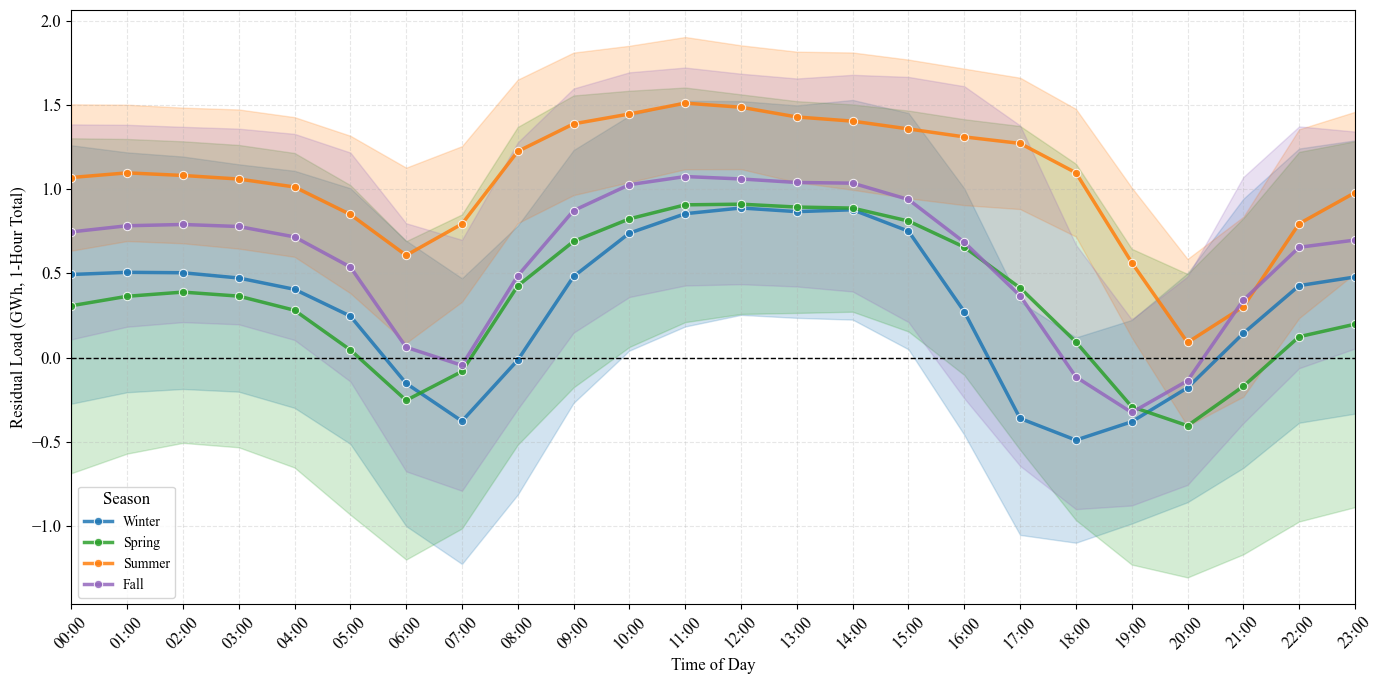

In [33]:
reanalysis['Hour'] = pd.to_datetime(reanalysis['LocalTime']).dt.hour
reanalysis['Hour'] = reanalysis['Hour'].astype(str).str.zfill(2) + ":00"

# Set 'Hour' as ordered categorical to fix x-axis
hour_labels = [f"{str(h).zfill(2)}:00" for h in range(24)]
reanalysis['Hour'] = pd.Categorical(reanalysis['Hour'], categories=hour_labels, ordered=True)

grouped = reanalysis.groupby(['Season', 'Date', 'Hour'])['Residual Load (GWh) EDP'].sum().reset_index()
grouped = grouped[grouped['Residual Load (GWh) EDP'] != 0]
season_palette = {
    'Winter': '#1f77b4',   # Blue
    'Spring': '#2ca02c',   # Green
    'Summer': '#ff7f0e',   # Orange
    'Fall': '#9467bd',   # Purple
}

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=grouped,
    x='Hour',
    y='Residual Load (GWh) EDP',
    hue='Season',
    palette=season_palette,
    hue_order=['Winter', 'Spring', 'Summer', 'Fall'],
    estimator='mean',
    errorbar='sd',
    linewidth=2.5,
    marker='o',
    markersize=6,
    err_style='band',
    alpha=0.85
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Residual Load (GWh, 1-Hour Total)', fontsize=12)
plt.xlim('00:00', '23:00')
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Season', title_fontsize=12, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
reanalysis['Residual Load (GWh) EDP'].mean()     

0.13707132017275547

In [35]:
reanalysis['Residual Load (GWh) EDP'].max() 

0.6227084840009998

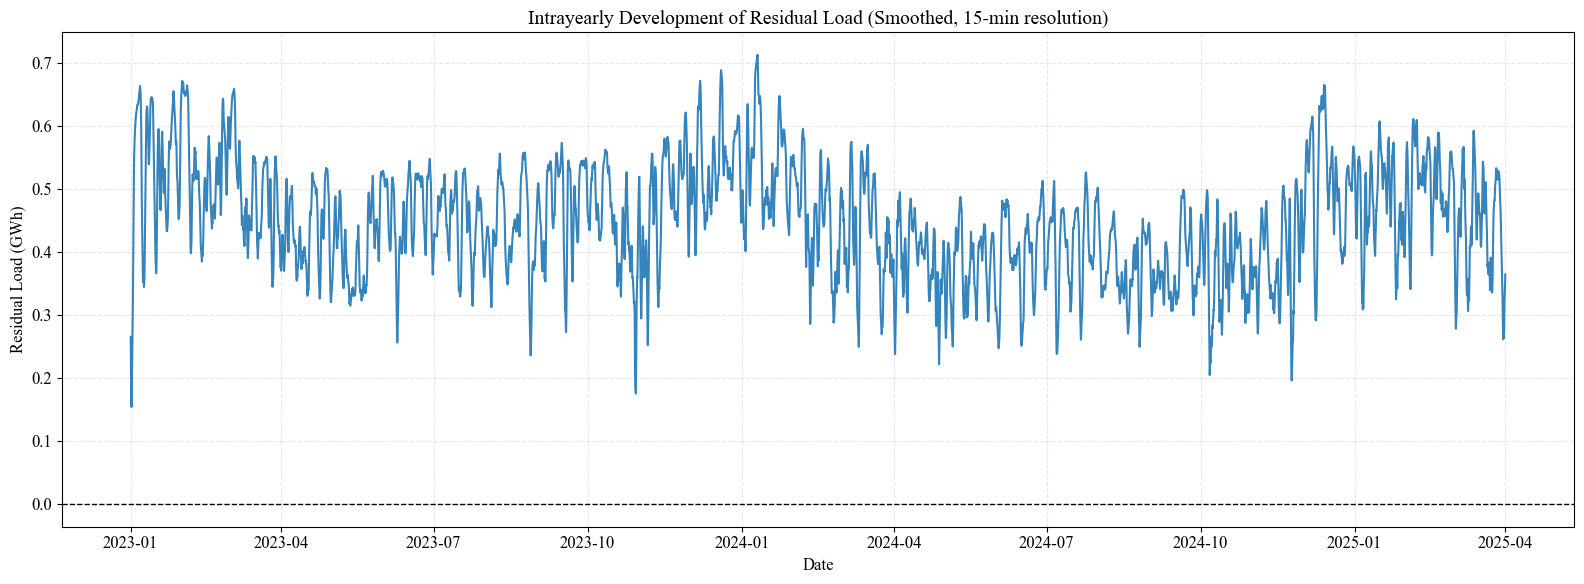

In [36]:
reanalysis_all.set_index('LocalTime', inplace=True)

# Apply rolling average with a 1-day window (96 intervals for 15-min data)
reanalysis_all['Residual Load Smoothed'] = reanalysis_all['Residual Load (GWh) EDP ex Hydro'].rolling(window=96, min_periods=1).mean()

# Reset index for plotting
reanalysis_all.reset_index(inplace=True)

# Plot intrayearly trend
plt.figure(figsize=(16, 6))
sns.lineplot(
    data=reanalysis_all,
    x='LocalTime',
    y='Residual Load Smoothed',
    linewidth=1.5,
    alpha=0.9
)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Intrayearly Development of Residual Load (Smoothed, 15-min resolution)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Residual Load (GWh)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

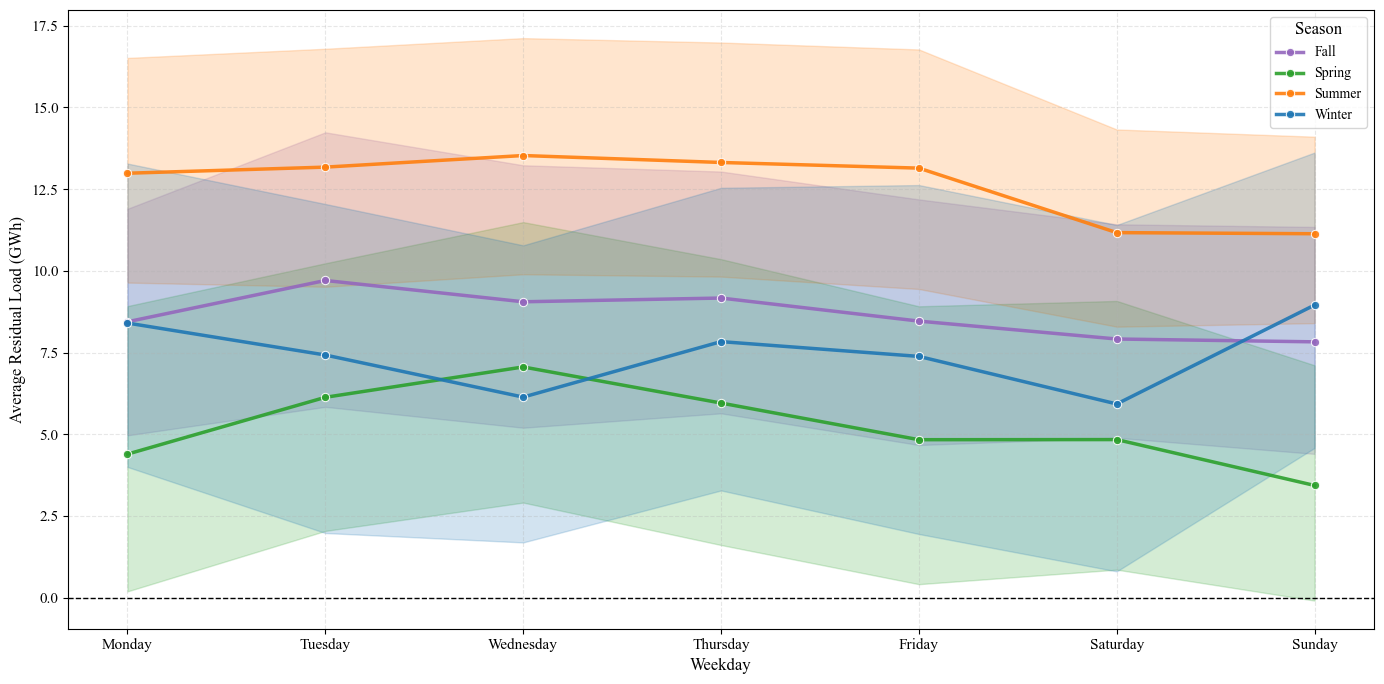

In [37]:
# Group to get total per 2-hour interval per day
grouped_weekday = reanalysis.groupby(['Season', 'Weekday', 'Date'])['Residual Load (GWh) EDP'].sum().reset_index()
season_palette = {
    'Winter': '#1f77b4',   # Blue
    'Spring': '#2ca02c',   # Green
    'Summer': '#ff7f0e',   # Orange
    'Fall': '#9467bd',   # Purple
}

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_dtype = CategoricalDtype(categories=weekday_order, ordered=True)
grouped_weekday['Weekday'] = grouped_weekday['Weekday'].astype(weekday_dtype)

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=grouped_weekday,
    x='Weekday',
    y='Residual Load (GWh) EDP',
    hue='Season',
    palette=season_palette,
    marker='o',
    linewidth=2.5,
    markersize=6,
    alpha=0.9
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Average Residual Load (GWh)', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Season', title_fontsize=12, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_23638/3747629567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reanalysis['Date'] = pd.to_datetime(reanalysis['Date'])
/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_23638/3747629567.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reanalysis['Weekday'] = reanalysis['Date'].dt.day_name()


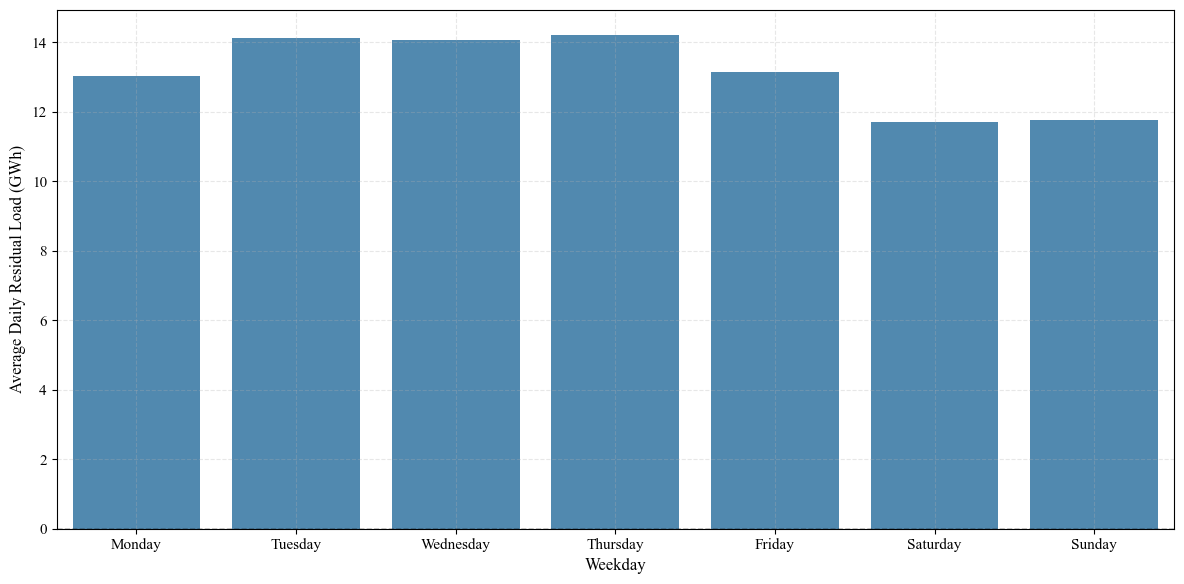

In [38]:
# Ensure datetime format
reanalysis['Date'] = pd.to_datetime(reanalysis['Date'])

# Add weekday column
reanalysis['Weekday'] = reanalysis['Date'].dt.day_name()

# Sum 15-min data to daily totals
daily_totals = reanalysis.groupby(['Date', 'Weekday'])['Residual Load (GWh) EDP'].sum().reset_index()

# Now average over weekdays
weekday_avg = daily_totals.groupby('Weekday')['Residual Load (GWh) EDP'].mean().reset_index()

# Order weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_dtype = CategoricalDtype(categories=weekday_order, ordered=True)
weekday_avg['Weekday'] = weekday_avg['Weekday'].astype(weekday_dtype)
weekday_avg = weekday_avg.sort_values('Weekday')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=weekday_avg,
    x='Weekday',
    y='Residual Load (GWh) EDP',
    color='#1f77b4',
    alpha=0.85
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Average Daily Residual Load (GWh)', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Volatility of VRE's ex Hydro

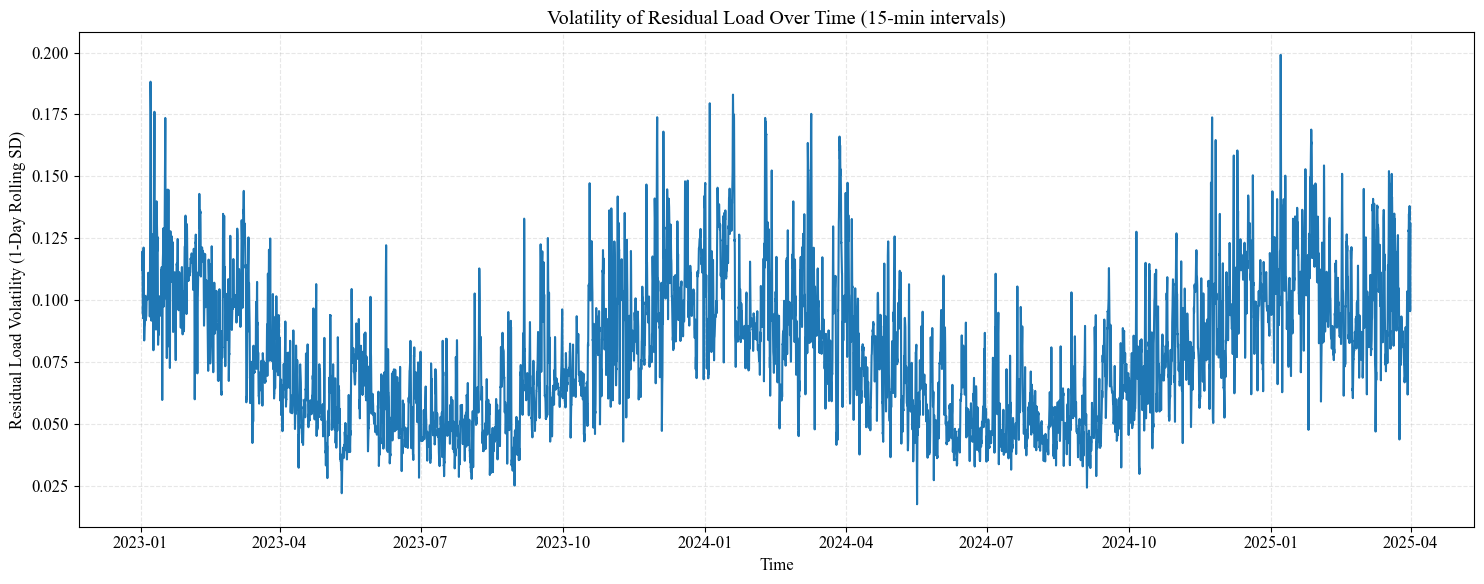

In [12]:
# Ensure datetime is sorted
reanalysis_copy = reanalysis.copy().sort_values('LocalTime')  # assuming LocalTime is datetime

# Set LocalTime as index if not already
reanalysis_copy.set_index('LocalTime', inplace=True)

# Rolling volatility over 1 day (96 intervals = 15-min × 96 = 24 hours)
reanalysis_copy['Volatility (1d SD)'] = reanalysis_copy['Residual Load (GWh) EDP ex Hydro'].rolling(window=96).std()

plt.figure(figsize=(15, 6))
plt.plot(reanalysis_copy.index, reanalysis_copy['Volatility (1d SD)'], linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Residual Load Volatility (1-Day Rolling SD)')
plt.title('Volatility of Residual Load Over Time (15-min intervals)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Volatility of VRE's w Hydro

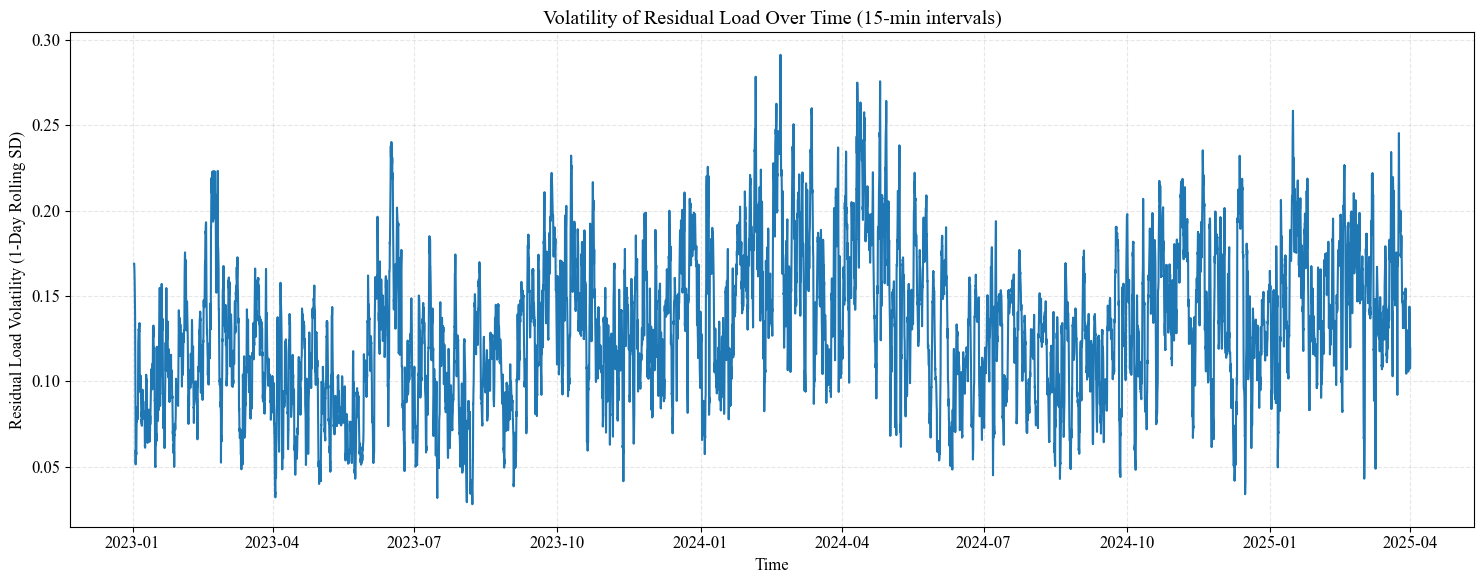

In [13]:
# Ensure datetime is sorted
reanalysis_copy = reanalysis.copy().sort_values('LocalTime')  # assuming LocalTime is datetime

# Set LocalTime as index if not already
reanalysis_copy.set_index('LocalTime', inplace=True)

# Rolling volatility over 1 day (96 intervals = 15-min × 96 = 24 hours)
reanalysis_copy['Volatility (1d SD)'] = reanalysis_copy['Residual Load (GWh) EDP'].rolling(window=96).std()

plt.figure(figsize=(15, 6))
plt.plot(reanalysis_copy.index, reanalysis_copy['Volatility (1d SD)'], linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Residual Load Volatility (1-Day Rolling SD)')
plt.title('Volatility of Residual Load Over Time (15-min intervals)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Fall: 95% CI for peak = 0.31 to 0.35 GWh
Spring: 95% CI for peak = 0.27 to 0.31 GWh
Summer: 95% CI for peak = 0.40 to 0.42 GWh
Winter: 95% CI for peak = 0.27 to 0.31 GWh


/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_23749/891398718.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


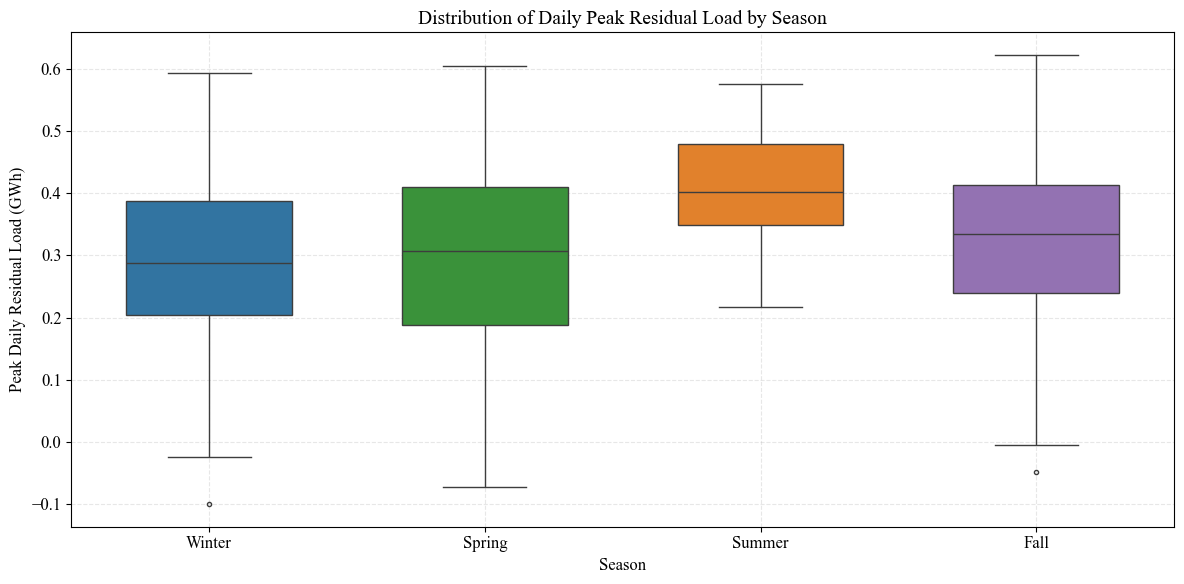

In [15]:
season_palette = {
    'Winter': '#1f77b4',
    'Spring': '#2ca02c',
    'Summer': '#ff7f0e',
    'Fall': '#9467bd',
}

reanalysis = reanalysis.reset_index()

reanalysis['Season'] = reanalysis['LocalTime'].dt.month % 12 // 3
season_map = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Fall'}
reanalysis['Season'] = reanalysis['Season'].map(season_map)

# Get peak residual load per day
daily_peaks = reanalysis.groupby(['Date', 'Season'])['Residual Load (GWh) EDP'].max().reset_index()
daily_peaks.rename(columns={'Residual Load (GWh) EDP': 'Peak Residual Load'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=daily_peaks,
    x='Season',
    y='Peak Residual Load',
    palette=season_palette,
    width=0.6,
    fliersize=3  # to show outliers
)

import scipy.stats as stats

for season, group in daily_peaks.groupby('Season'):
    if len(group) < 2:
        print(f"{season}: Not enough data for CI (n={len(group)})")
        continue
    mean = group['Peak Residual Load'].mean()
    sem = stats.sem(group['Peak Residual Load'])
    ci = stats.t.interval(0.95, len(group)-1, loc=mean, scale=sem)
    print(f"{season}: 95% CI for peak = {ci[0]:.2f} to {ci[1]:.2f} GWh")

plt.ylabel('Peak Daily Residual Load (GWh)', fontsize=12)
plt.xlabel('Season', fontsize=12)
plt.title('Distribution of Daily Peak Residual Load by Season', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Fall: 95% CI for daily residual load = 12.02 to 16.15 GWh
Spring: 95% CI for daily residual load = 5.78 to 10.97 GWh
Summer: 95% CI for daily residual load = 24.10 to 26.43 GWh
Winter: 95% CI for daily residual load = 5.60 to 9.31 GWh


/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_23749/1665558089.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


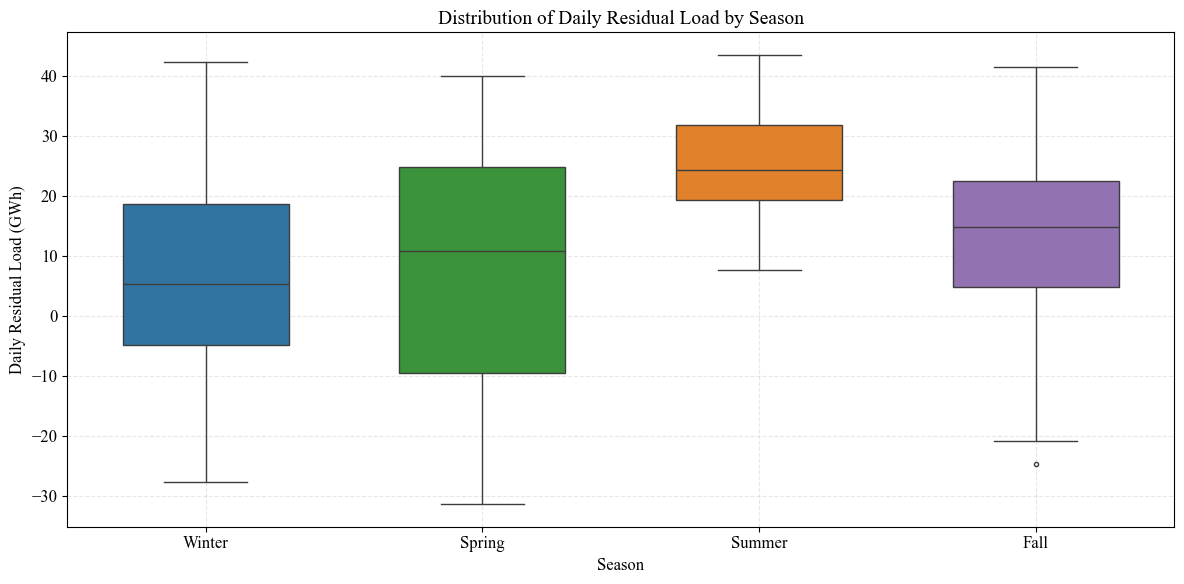

In [16]:
daily_totals = reanalysis.groupby(['Date', 'Season'])['Residual Load (GWh) EDP'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=daily_totals,
    x='Season',
    y='Residual Load (GWh) EDP',
    palette=season_palette,
    width=0.6,
    fliersize=3 
)

# Compute and print 95% confidence intervals per season
import scipy.stats as stats

for season, group in daily_totals.groupby('Season'):
    if len(group) < 2:
        print(f"{season}: Not enough data for CI (n={len(group)})")
        continue
    mean = group['Residual Load (GWh) EDP'].mean()
    sem = stats.sem(group['Residual Load (GWh) EDP'])
    ci = stats.t.interval(0.95, len(group)-1, loc=mean, scale=sem)
    print(f"{season}: 95% CI for daily residual load = {ci[0]:.2f} to {ci[1]:.2f} GWh")

plt.ylabel('Daily Residual Load (GWh)', fontsize=12)
plt.xlabel('Season', fontsize=12)
plt.title('Distribution of Daily Residual Load by Season', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_23749/3037702412.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_23749/3037702412.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


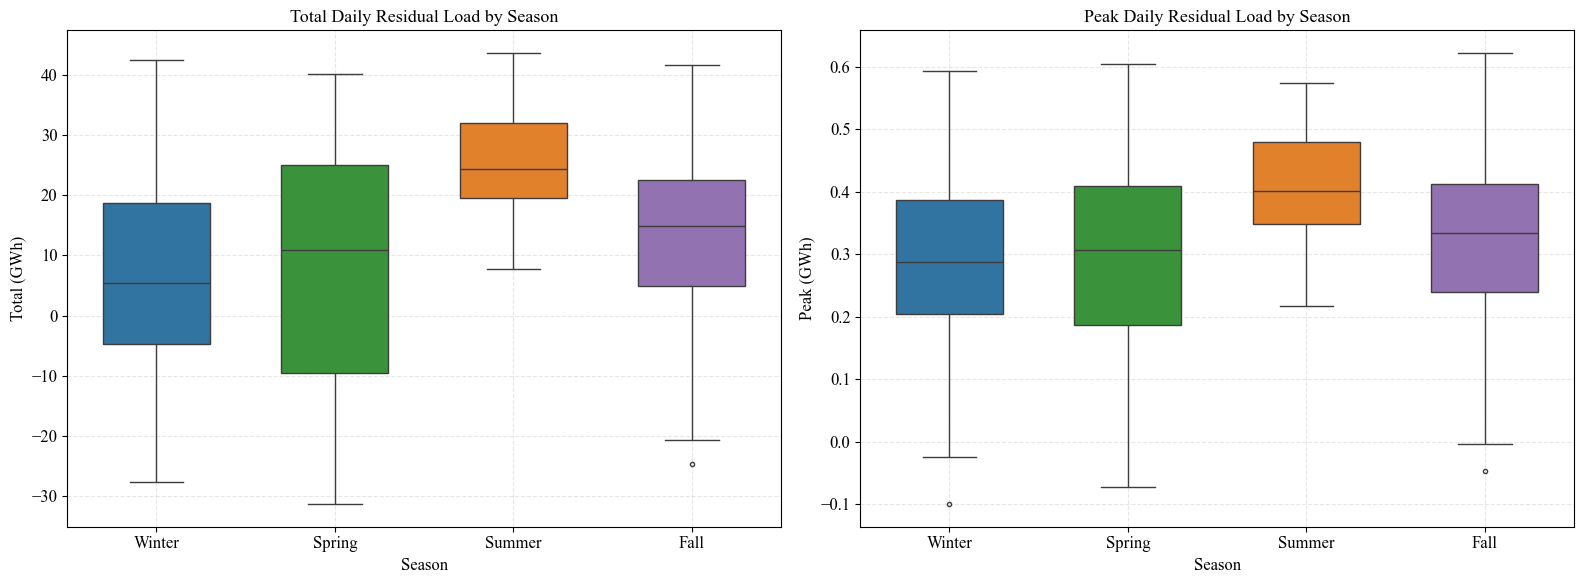


--- 95% Confidence Intervals for Peak Daily Residual Load ---
Fall: 95% CI = 0.31 to 0.35 GWh
Spring: 95% CI = 0.27 to 0.31 GWh
Summer: 95% CI = 0.40 to 0.42 GWh
Winter: 95% CI = 0.27 to 0.31 GWh


In [17]:
# Palette
season_palette = {
    'Winter': '#1f77b4',
    'Spring': '#2ca02c',
    'Summer': '#ff7f0e',
    'Fall': '#9467bd',
}

# Get total and peak residual load per day
daily_totals = reanalysis.groupby(['Date', 'Season'])['Residual Load (GWh) EDP'].sum().reset_index()
daily_peaks = reanalysis.groupby(['Date', 'Season'])['Residual Load (GWh) EDP'].max().reset_index()
daily_peaks.rename(columns={'Residual Load (GWh) EDP': 'Peak Residual Load'}, inplace=True)

# Set up figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# --- Boxplot: Total Daily Residual Load ---
sns.boxplot(
    data=daily_totals,
    x='Season',
    y='Residual Load (GWh) EDP',
    palette=season_palette,
    width=0.6,
    fliersize=3,
    ax=axes[0]
)
axes[0].set_title('Total Daily Residual Load by Season', fontsize=13)
axes[0].set_xlabel('Season', fontsize=12)
axes[0].set_ylabel('Total (GWh)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.3)

# --- Boxplot: Peak Daily Residual Load ---
sns.boxplot(
    data=daily_peaks,
    x='Season',
    y='Peak Residual Load',
    palette=season_palette,
    width=0.6,
    fliersize=3,
    ax=axes[1]
)
axes[1].set_title('Peak Daily Residual Load by Season', fontsize=13)
axes[1].set_xlabel('Season', fontsize=12)
axes[1].set_ylabel('Peak (GWh)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# --- Optional: Print 95% Confidence Intervals ---
print("\n--- 95% Confidence Intervals for Peak Daily Residual Load ---")
for season, group in daily_peaks.groupby('Season'):
    if len(group) < 2:
        print(f"{season}: Not enough data for CI (n={len(group)})")
        continue
    mean = group['Peak Residual Load'].mean()
    sem = stats.sem(group['Peak Residual Load'])
    ci = stats.t.interval(0.95, len(group)-1, loc=mean, scale=sem)
    print(f"{season}: 95% CI = {ci[0]:.2f} to {ci[1]:.2f} GWh")

Positive residual load occurs 73.84% of the time.
That corresponds to approximately 14547.8 hours.
Negative residual load occurs 26.16% of the time.
That corresponds to approximately 5154.2 hours.


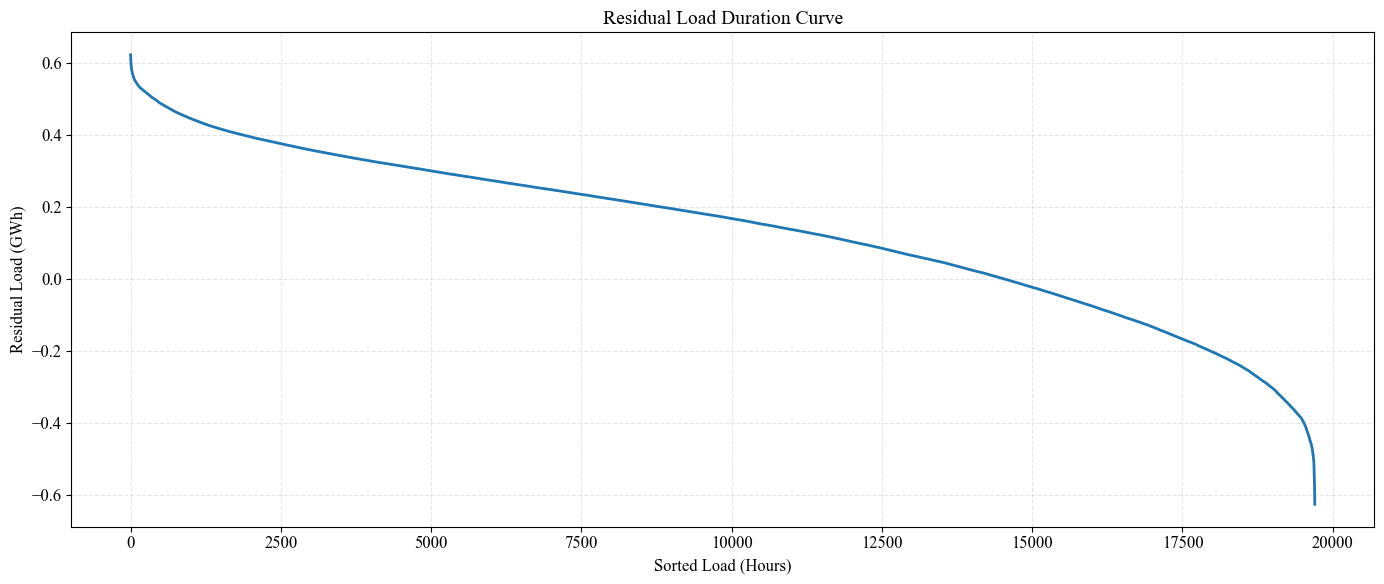

In [20]:
ldc = reanalysis[['LocalTime', 'Residual Load (GWh) EDP']].copy()
ldc = ldc.sort_values(by='Residual Load (GWh) EDP', ascending=False).reset_index(drop=True)

# Add a duration rank (interval index)
ldc['Hour Rank'] = ldc.index / 4  # because 4 intervals per hour (15min data)

# Calculate positive residual load stats
positive_rl = ldc[ldc['Residual Load (GWh) EDP'] > 0]
negative_rl = ldc[ldc['Residual Load (GWh) EDP'] < 0]
total_intervals = len(ldc)
positive_intervals = len(positive_rl)
negative_intervals = len(negative_rl)
positive_percentage = (positive_intervals / total_intervals) * 100
negative_percentage = (negative_intervals / total_intervals) * 100
positive_hours = positive_intervals / 4
negative_hours = negative_intervals / 4

# Print stats
print(f"Positive residual load occurs {positive_percentage:.2f}% of the time.")
print(f"That corresponds to approximately {positive_hours:.1f} hours.")
print(f"Negative residual load occurs {negative_percentage:.2f}% of the time.")
print(f"That corresponds to approximately {negative_hours:.1f} hours.")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(ldc['Hour Rank'], ldc['Residual Load (GWh) EDP'], linewidth=2)

plt.xlabel('Sorted Load (Hours)', fontsize=12)
plt.ylabel('Residual Load (GWh)', fontsize=12)
plt.title('Residual Load Duration Curve', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

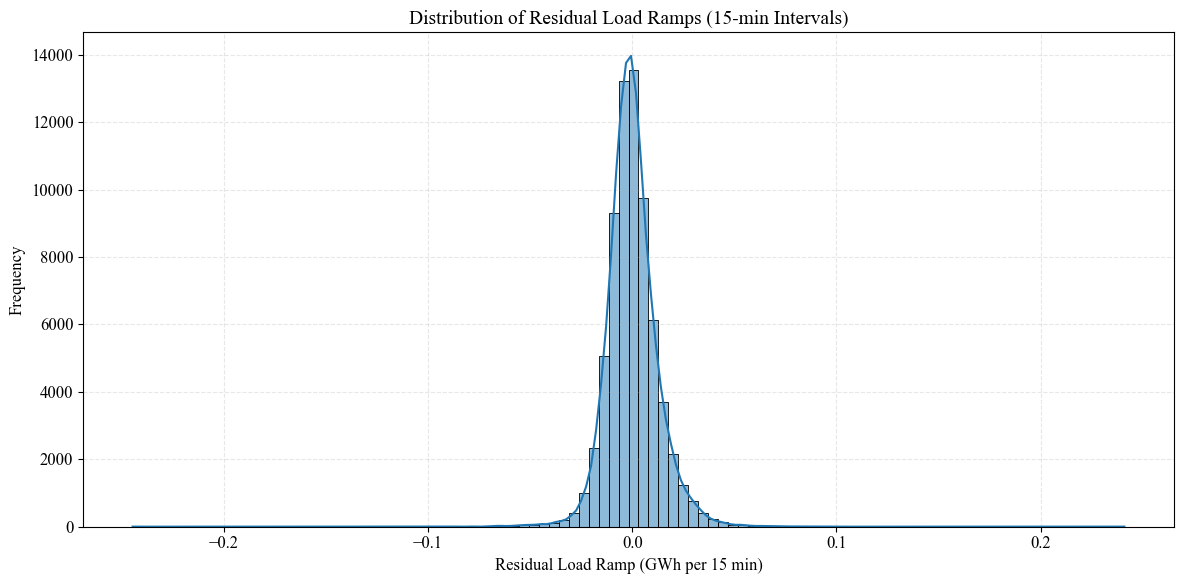

In [71]:
reanalysis = reanalysis.sort_values('LocalTime')
reanalysis['Residual Ramp (GWh)'] = reanalysis['Residual Load (GWh) EDP'].diff()

plt.figure(figsize=(12, 6))
sns.histplot(reanalysis['Residual Ramp (GWh)'], bins=100, kde=True)

plt.xlabel('Residual Load Ramp (GWh per 15 min)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Residual Load Ramps (15-min Intervals)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

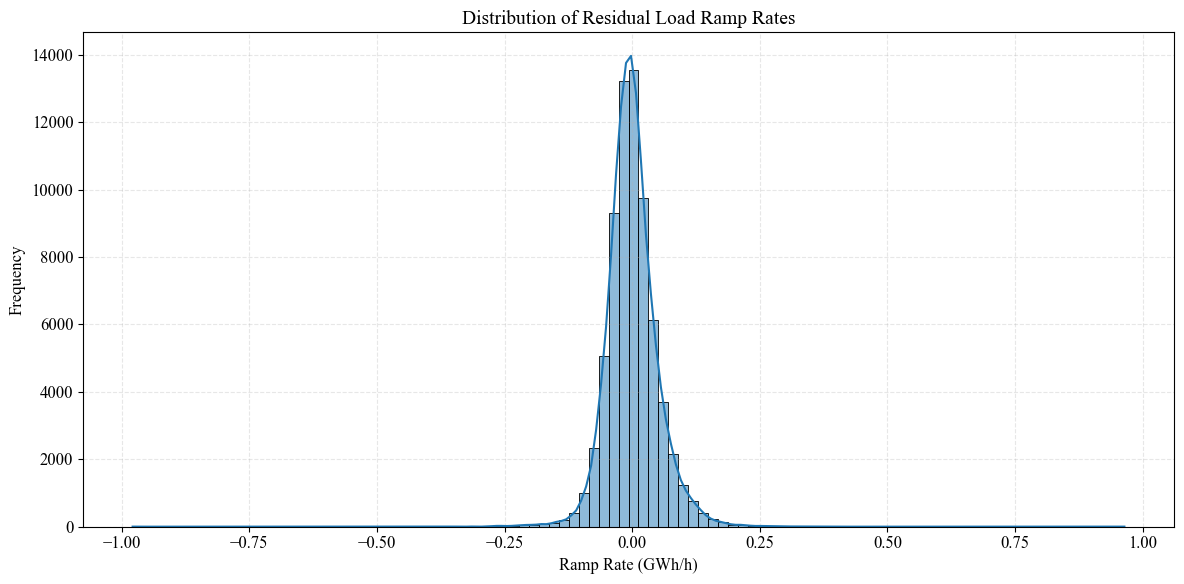

In [72]:
reanalysis = reanalysis.sort_values('LocalTime')

# Calculate ramp in GWh per 15-min, then scale to per-hour
reanalysis['Ramp Rate (GWh/h)'] = reanalysis['Residual Load (GWh) EDP'].diff() / 0.25

plt.figure(figsize=(12, 6))
sns.histplot(reanalysis['Ramp Rate (GWh/h)'], bins=100, kde=True)

plt.xlabel('Ramp Rate (GWh/h)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Residual Load Ramp Rates', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [74]:
# Absolute ramp rate for total daily effort
reanalysis['Abs Ramp Rate'] = reanalysis['Ramp Rate (GWh/h)'].abs()

# Group by date
daily_ramps = reanalysis.groupby('Date').agg({
    'Ramp Rate (GWh/h)': ['max', 'min'],
    'Abs Ramp Rate': 'sum'
}).reset_index()

# Clean column names
daily_ramps.columns = ['Date', 'Max Ramp Rate', 'Min Ramp Rate', 'Total Daily Ramping Effort']

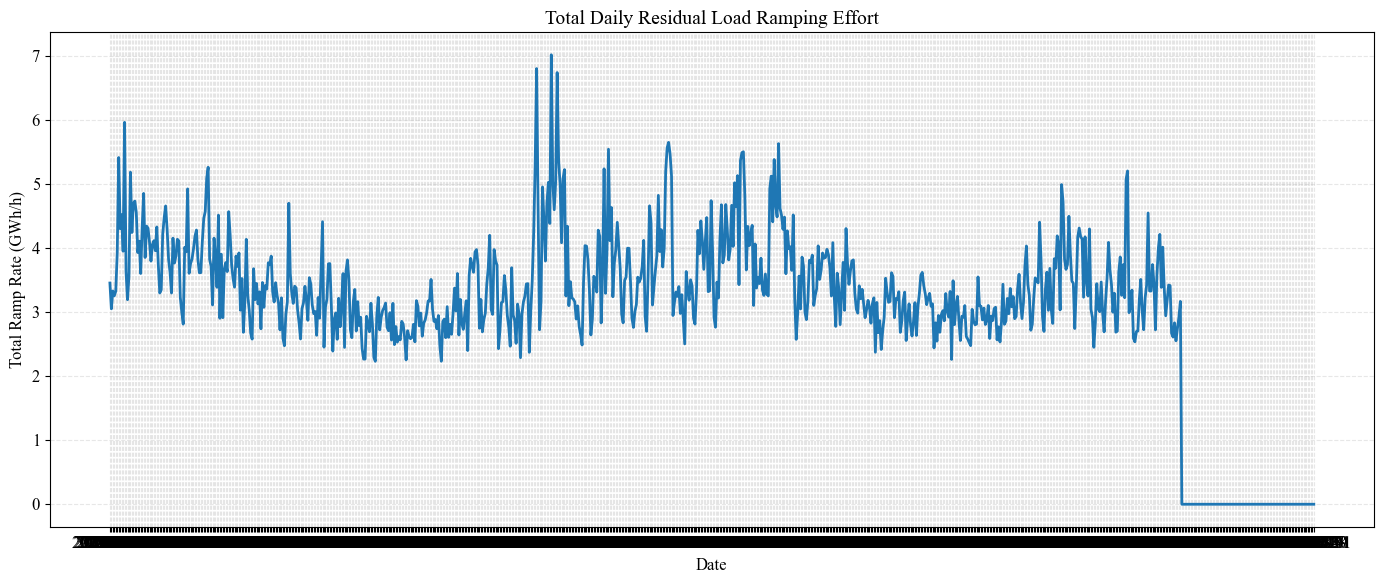

In [75]:
plt.figure(figsize=(14, 6))
plt.plot(daily_ramps['Date'], daily_ramps['Total Daily Ramping Effort'], linewidth=2)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Ramp Rate (GWh/h)', fontsize=12)
plt.title('Total Daily Residual Load Ramping Effort', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

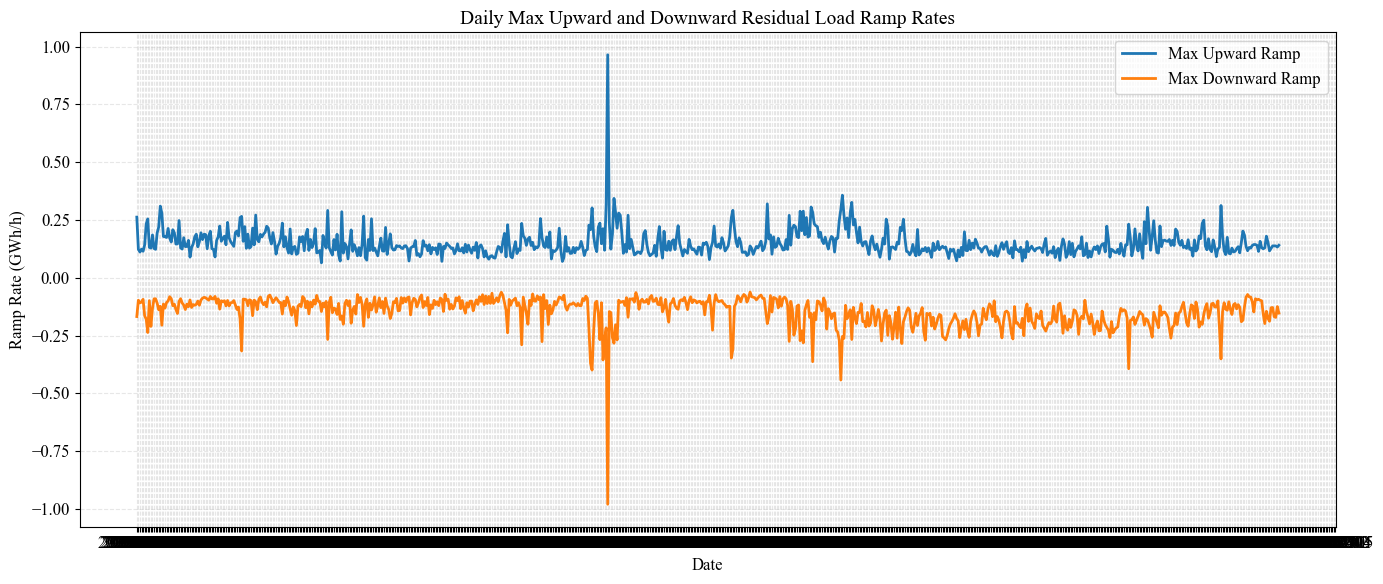

In [76]:
plt.figure(figsize=(14, 6))
plt.plot(daily_ramps['Date'], daily_ramps['Max Ramp Rate'], label='Max Upward Ramp', linewidth=2)
plt.plot(daily_ramps['Date'], daily_ramps['Min Ramp Rate'], label='Max Downward Ramp', linewidth=2)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Ramp Rate (GWh/h)', fontsize=12)
plt.title('Daily Max Upward and Downward Residual Load Ramp Rates', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [77]:
reanalysis = reanalysis.sort_values('LocalTime')

# Ramps in GWh over 15-min intervals
reanalysis['Residual Ramp'] = reanalysis['Residual Load (GWh) EDP'].diff()
reanalysis['Prod Ramp'] = reanalysis['Total Prod in GWh EDP'].diff()
reanalysis['Con Ramp'] = reanalysis['Total Con (GWh)'].diff()

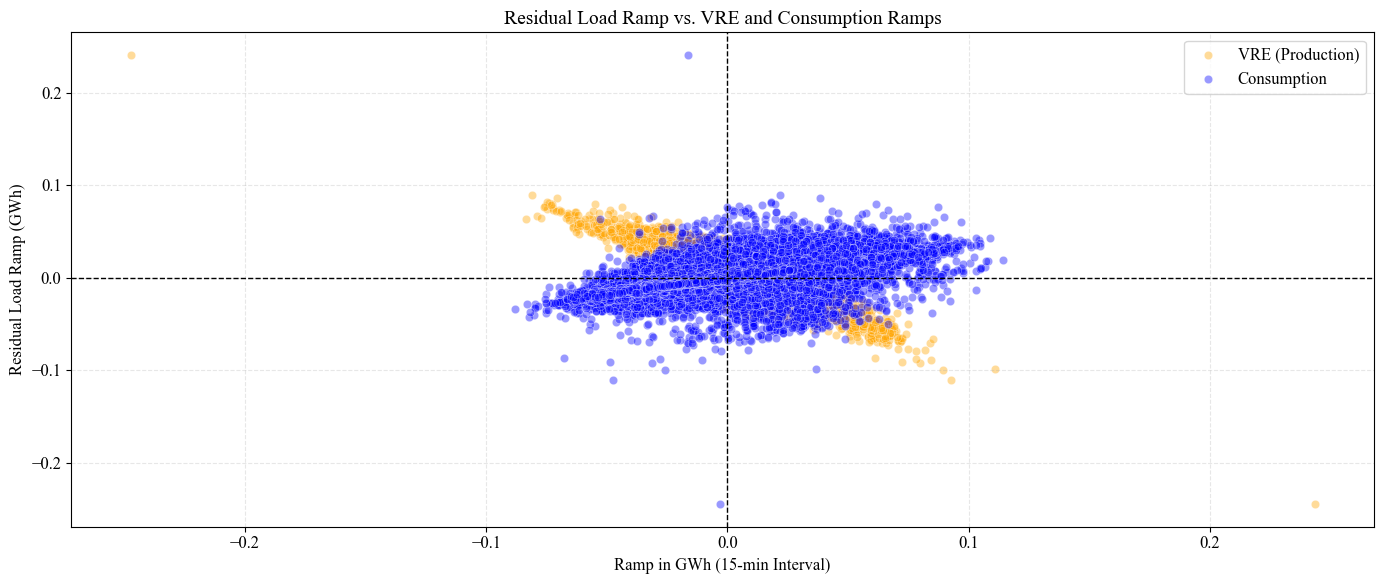

In [78]:
plt.figure(figsize=(14, 6))

# Compare residual vs production ramps
sns.scatterplot(
    data=reanalysis,
    x='Prod Ramp',
    y='Residual Ramp',
    alpha=0.4,
    label='VRE (Production)',
    color='orange'
)

# Compare residual vs consumption ramps
sns.scatterplot(
    data=reanalysis,
    x='Con Ramp',
    y='Residual Ramp',
    alpha=0.4,
    label='Consumption',
    color='blue'
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Ramp in GWh (15-min Interval)', fontsize=12)
plt.ylabel('Residual Load Ramp (GWh)', fontsize=12)
plt.title('Residual Load Ramp vs. VRE and Consumption Ramps', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [79]:
print("Correlation with Production Ramp:", reanalysis['Residual Ramp'].corr(reanalysis['Prod Ramp']))
print("Correlation with Consumption Ramp:", reanalysis['Residual Ramp'].corr(reanalysis['Con Ramp']))

Correlation with Production Ramp: -0.6994294808744123
Correlation with Consumption Ramp: 0.6372565471928056


In [30]:
print("Correlation with Country Wide Residual Load", reanalysis_all['Residual Load (GWh)'].corr(reanalysis_all['Residual Load (GWh) EDP']))

Correlation with Country Wide Residual Load 0.8359601615201069


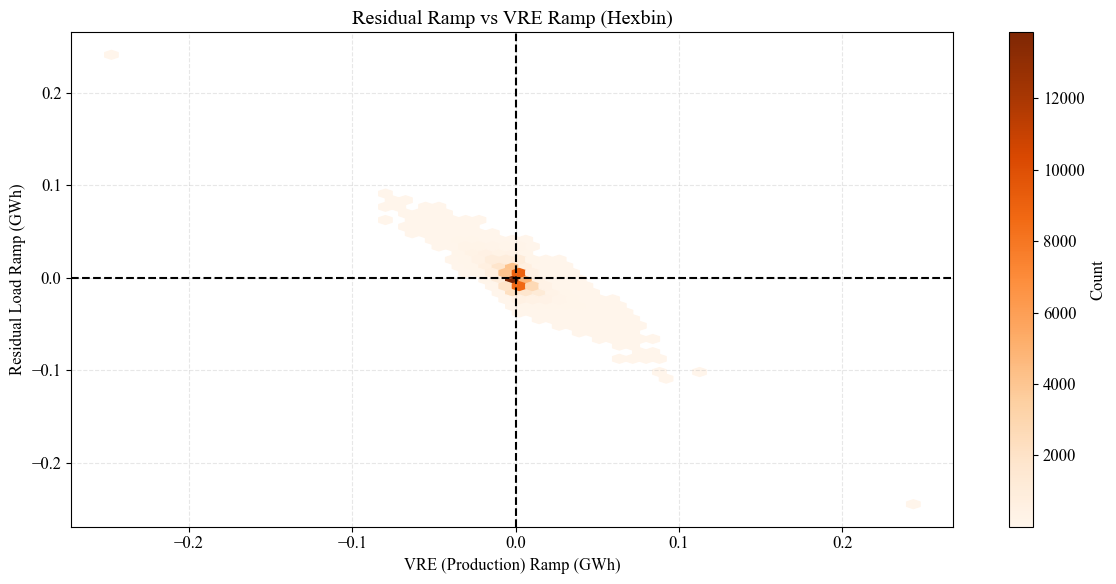

In [81]:
plt.figure(figsize=(12, 6))
plt.hexbin(
    reanalysis['Prod Ramp'],
    reanalysis['Residual Ramp'],
    gridsize=60,
    cmap='Oranges',
    mincnt=1
)
plt.colorbar(label='Count')
plt.xlabel('VRE (Production) Ramp (GWh)')
plt.ylabel('Residual Load Ramp (GWh)')
plt.title('Residual Ramp vs VRE Ramp (Hexbin)')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Calculations

### Adding Bitcoin Data

In [21]:
reanalysis['avg_bitcoin_price'] = reanalysis['avg_bitcoin_price'].fillna(method='ffill')

/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_23749/1228469008.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  reanalysis['avg_bitcoin_price'] = reanalysis['avg_bitcoin_price'].fillna(method='ffill')


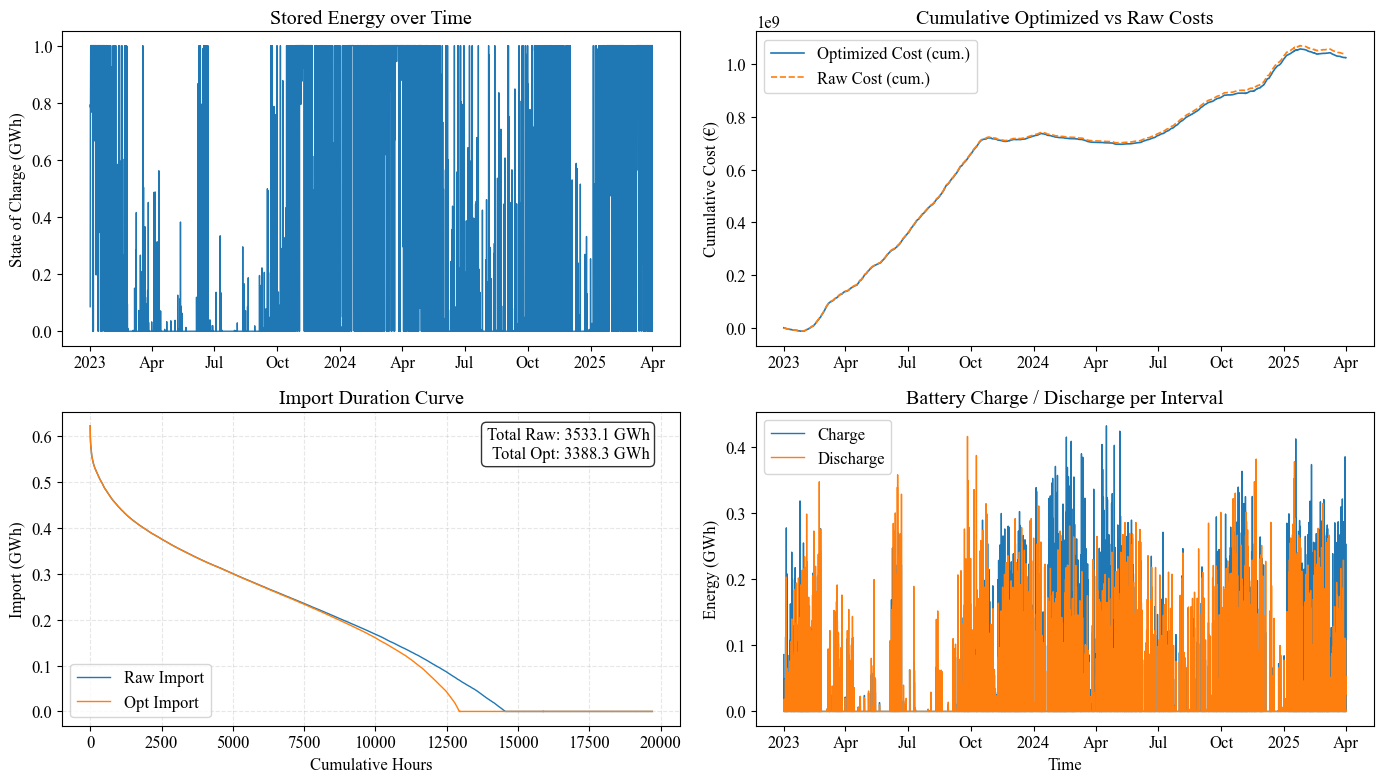

,Stored Energy (GWh),Charge (GWh),Discharge (GWh),Raw Import (GWh),Opt Import (GWh),Battery Throughput (GWh),Residual Load (GWh) EDP Optimized,Cost,Optimized Cost (€),Total Cost (€),Storage Depreciation (€)
Year,,,,,,,,,,,
2023,5735.046182,173.484299,173.484299,8211.460161,8037.975862,346.968598,7466.253040,7.325109e+08,7.283089e+08,7.283543e+08,45403.887249
2024,10377.060889,305.504008,305.504008,5146.609298,4841.105290,611.008017,3260.687415,3.024961e+08,2.950940e+08,2.951396e+08,45529.566473
2025,4519.414140,100.590746,99.590746,773.724672,674.133925,200.181493,76.376146,5.585499e+06,2.683662e+06,2.694857e+06,11194.520811


In [168]:
reanalysis_storage_1_GWh = storing_energy_limited(reanalysis, storage_capacity_gwh=1)
plot_storage_results(reanalysis_storage_1_GWh)
cols_to_use = [
    'Year',
    'Stored Energy (GWh)',
    'Charge (GWh)',
    'Discharge (GWh)',
    'Raw Import (GWh)',
    'Opt Import (GWh)',
    'Battery Throughput (GWh)',
    'Residual Load (GWh) EDP Optimized',
    'Cost',
    'Optimized Cost (€)',
    'Total Cost (€)',
    'Storage Depreciation (€)',
]

reanalysis_storage_1_GWh[cols_to_use].groupby('Year').sum()

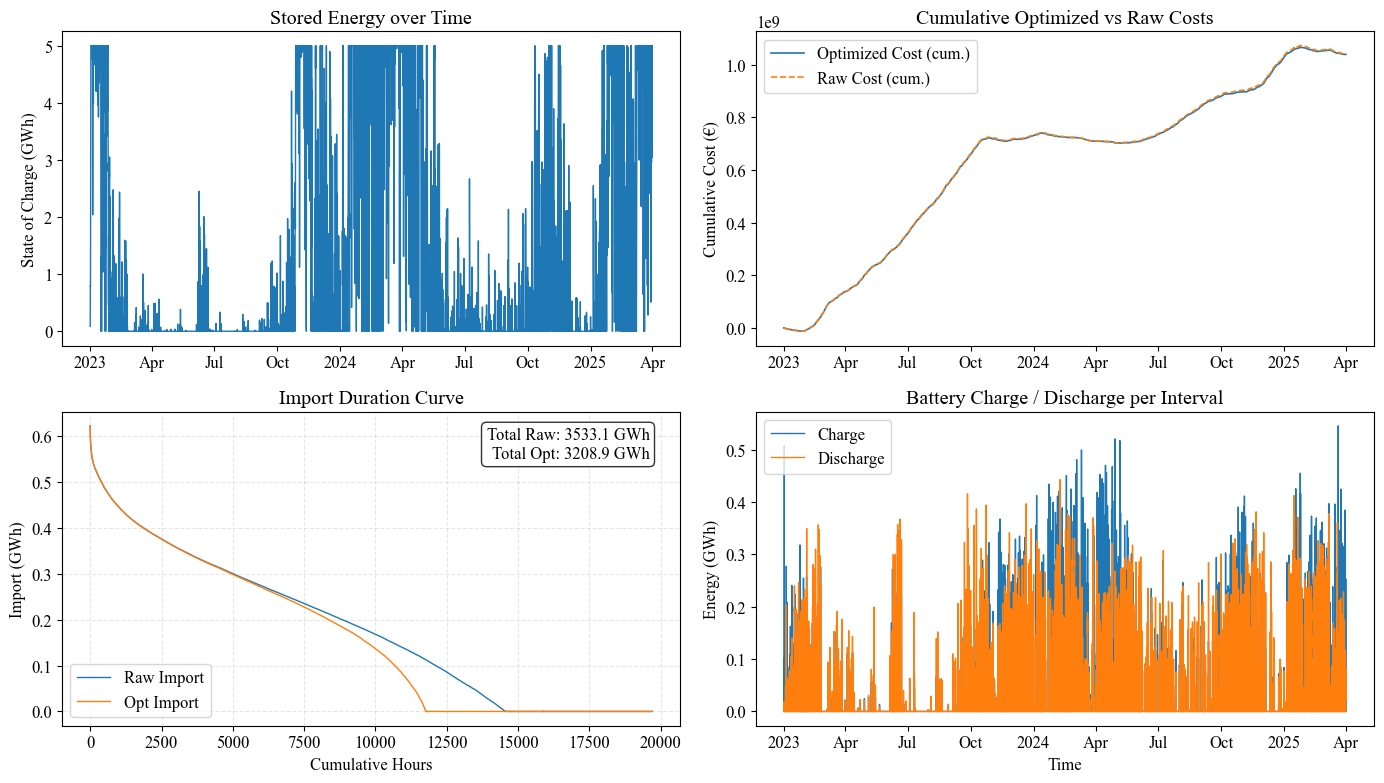

,Stored Energy (GWh),Charge (GWh),Discharge (GWh),Raw Import (GWh),Opt Import (GWh),Battery Throughput (GWh),Residual Load (GWh) EDP Optimized,Cost,Optimized Cost (€),Total Cost (€),Storage Depreciation (€)
Year,,,,,,,,,,,
2023,26330.780498,315.130559,315.130559,8211.460161,7896.329602,630.261117,7466.253040,7.325109e+08,7.302461e+08,7.304731e+08,227019.436247
2024,49866.385412,715.358031,715.358031,5146.609298,4431.251267,1430.716063,3260.687415,3.024961e+08,2.988451e+08,2.990727e+08,227647.832366
2025,22453.846234,270.720247,265.720247,773.724672,508.004425,536.440494,80.376146,5.585499e+06,9.063299e+06,9.119271e+06,55972.604055


In [170]:
reanalysis_storage_5_GWh = storing_energy_limited(reanalysis, storage_capacity_gwh=5)
plot_storage_results(reanalysis_storage_5_GWh)
cols_to_use = [
    'Year',
    'Stored Energy (GWh)',
    'Charge (GWh)',
    'Discharge (GWh)',
    'Raw Import (GWh)',
    'Opt Import (GWh)',
    'Battery Throughput (GWh)',
    'Residual Load (GWh) EDP Optimized',
    'Cost',
    'Optimized Cost (€)',
    'Total Cost (€)',
    'Storage Depreciation (€)',
]

reanalysis_storage_5_GWh[cols_to_use].groupby('Year').sum()

In [167]:
reanalysis.groupby('Year')['Cost'].sum()

Year
2023    7.325109e+08
2024    3.024961e+08
2025    5.585499e+06
Name: Cost, dtype: float64

→ Chosen price threshold = €161/MWh


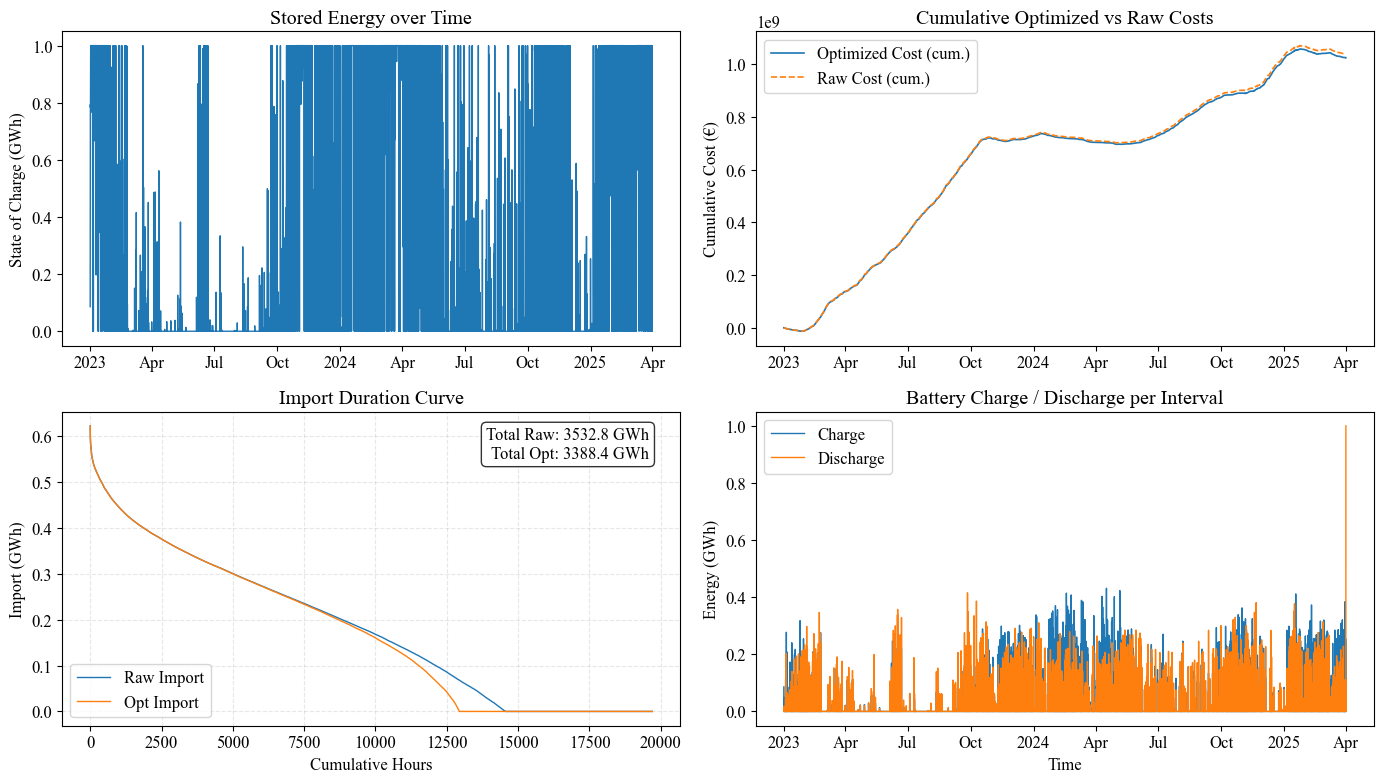

,Stored Energy (GWh),Charge (GWh),Discharge (GWh),Raw Import (GWh),Opt Import (GWh),Battery Throughput (GWh),Residual Load (GWh) EDP Optimized,Cost,Optimized Cost (€),Total Cost (€),Storage Depreciation (€)
Year,,,,,,,,,,,
2023,5723.216854,172.796222,172.796222,8211.460161,8038.663939,345.592445,7466.253040,7.325109e+08,7.282748e+08,7.736748e+08,4.540000e+07
2024,10373.378465,304.822554,304.822554,5146.609298,4841.786745,609.645107,3260.687415,3.024961e+08,2.950979e+08,3.406222e+08,4.552438e+07
2025,4507.684018,100.435429,100.435429,773.724672,674.289243,200.870857,76.687178,5.585499e+06,2.472322e+06,1.366166e+07,1.118934e+07


In [171]:
reanalysis_storage_w_price_1GWh = storing_energy_limited_w_price_fast(reanalysis, storage_capacity_gwh=1)
plot_storage_results(reanalysis_storage_w_price_1GWh)
cols_to_use = [
    'Year',
    'Stored Energy (GWh)',
    'Charge (GWh)',
    'Discharge (GWh)',
    'Raw Import (GWh)',
    'Opt Import (GWh)',
    'Battery Throughput (GWh)',
    'Residual Load (GWh) EDP Optimized',
    'Cost',
    'Optimized Cost (€)',
    'Total Cost (€)',
    'Storage Depreciation (€)',
]

reanalysis_storage_w_price_1GWh[cols_to_use].groupby('Year').sum()

→ Chosen price threshold = €143/MWh


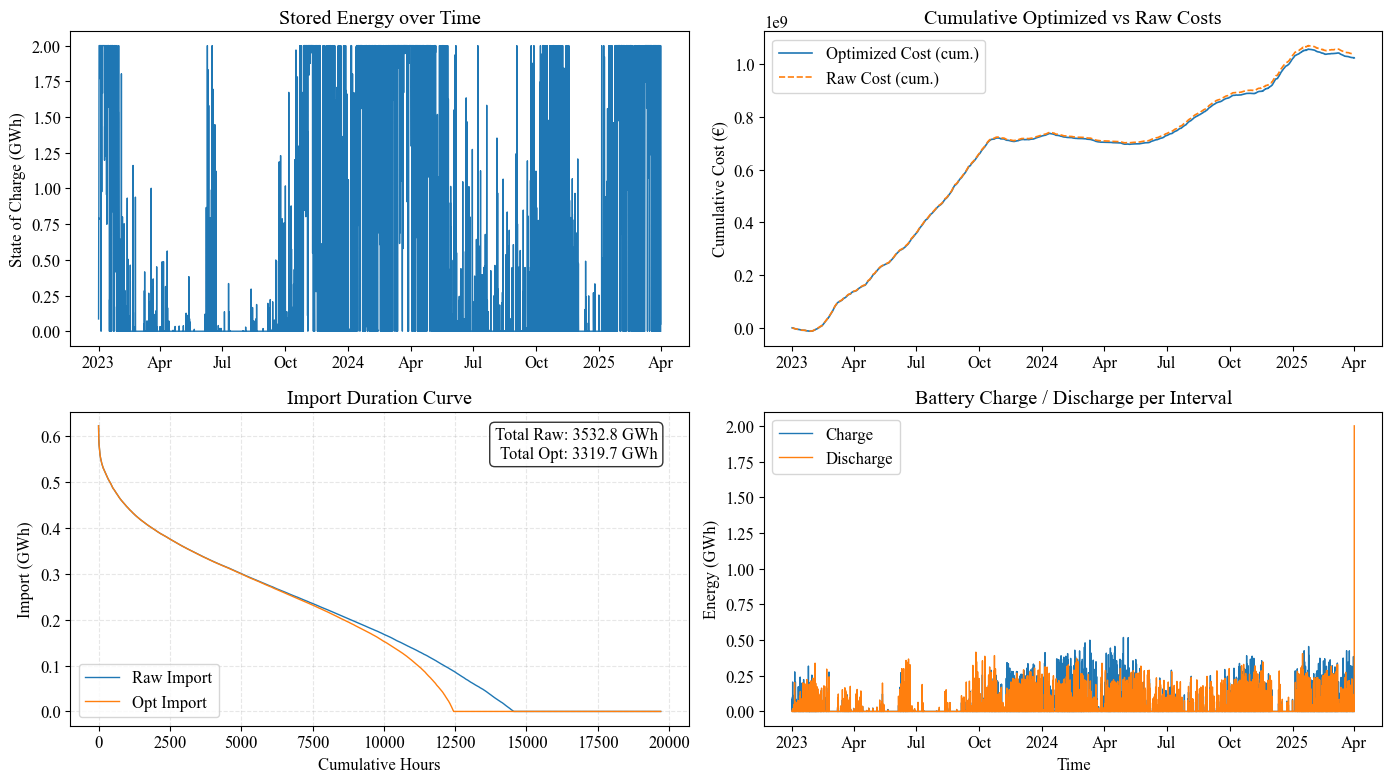

,Stored Energy (GWh),Charge (GWh),Discharge (GWh),Raw Import (GWh),Opt Import (GWh),Battery Throughput (GWh),Residual Load (GWh) EDP Optimized,Cost,Optimized Cost (€),Total Cost (€),Storage Depreciation (€)
Year,,,,,,,,,,,
2023,11024.523275,228.370917,228.370917,8211.460161,7983.089244,456.741833,7466.253040,7.325109e+08,7.283576e+08,8.191576e+08,9.080000e+07
2024,20618.620247,466.325977,466.325977,5146.609298,4680.283321,932.651955,3260.687415,3.024961e+08,2.941669e+08,3.852156e+08,9.104877e+07
2025,8767.581919,159.500862,159.500862,773.724672,616.223810,319.001723,77.687178,5.585499e+06,2.648685e+06,2.502736e+07,2.237868e+07


In [173]:
reanalysis_storage_w_price_2GWh = storing_energy_limited_w_price_fast(reanalysis, storage_capacity_gwh=2)
plot_storage_results(reanalysis_storage_w_price_2GWh)
cols_to_use = [
    'Year',
    'Stored Energy (GWh)',
    'Charge (GWh)',
    'Discharge (GWh)',
    'Raw Import (GWh)',
    'Opt Import (GWh)',
    'Battery Throughput (GWh)',
    'Residual Load (GWh) EDP Optimized',
    'Cost', # Baseline
    'Optimized Cost (€)',
    'Total Cost (€)',
    'Storage Depreciation (€)',
]

reanalysis_storage_w_price_2GWh[cols_to_use].groupby('Year').sum()

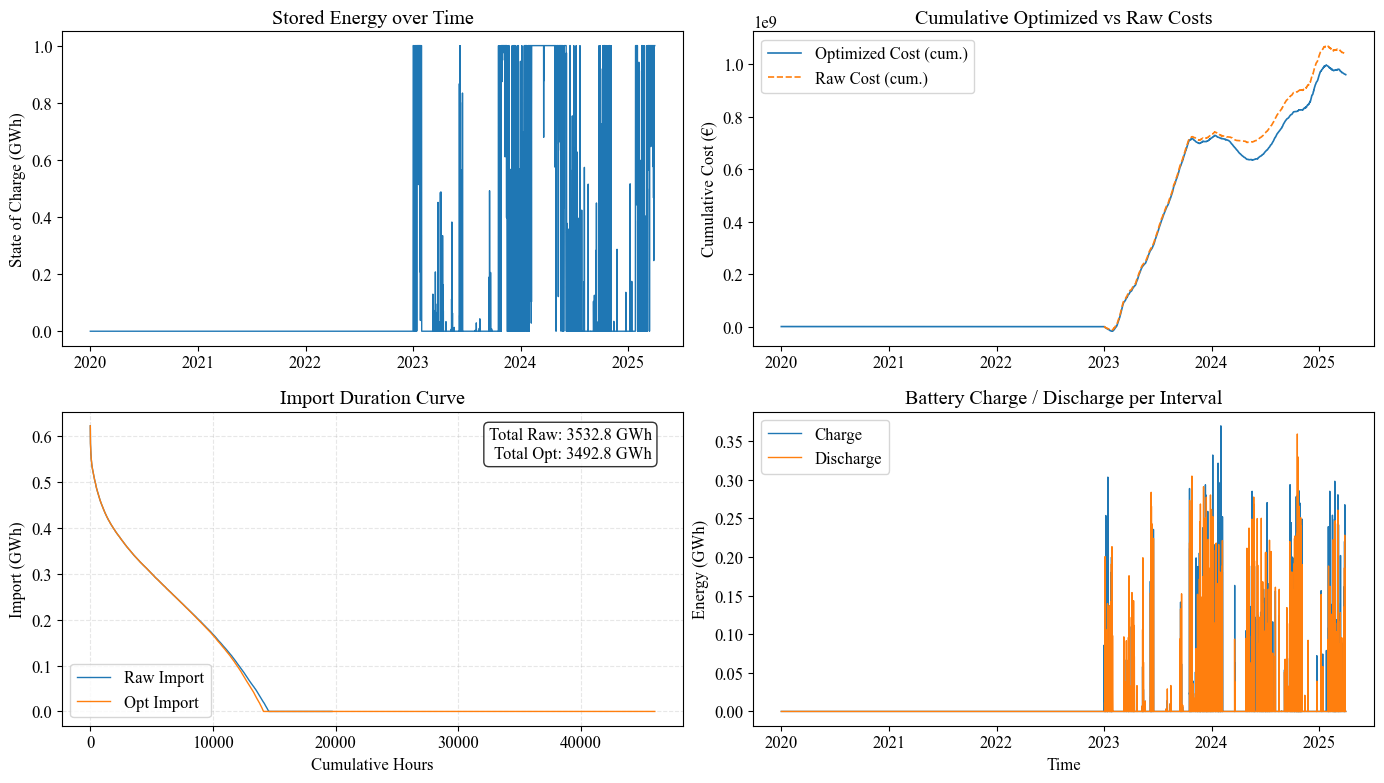

,Stored Energy (GWh),Charge (GWh),Discharge (GWh),Raw Import (GWh),Opt Import (GWh),Battery Throughput (GWh),Energy Cost (€),Energy Revenue (€),Mining Revenue (€),Hours Mined,BTC Mined,Mining Energy Cost (€),CapEx & O&M Cost (€),Storage Depreciation (€),Mining Profit (€),Saved Costs (€),Profit (€),Cost,Optimized Cost (€),Total Cost (€)
Year,,,,,,,,,,,,,,,,,,,,
2020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,2.429973e+08,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.429973e+08
2021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,2.423333e+08,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.423333e+08
2022,0.054519,0.054519,0.000000,0.000000,0.000000,0.054519,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,2.423333e+08,0.000000e+00,0.000000e+00,0.0,-8.723095e+02,0.000000e+00,2.423333e+08
2023,5496.111945,56.062492,56.117012,8210.468128,8154.351117,112.179504,7.796691e+08,3.277796e+07,2.790292e+07,513.067971,1053.282996,1.265141e+07,1.493736e+07,2.423887e+08,3.141457e+05,5.671944e+06,0.0,7.322417e+08,7.189882e+08,9.616719e+08
2024,14261.005660,82.873961,82.873961,5146.819462,5063.945501,165.747921,3.776173e+08,9.488820e+06,1.266082e+08,1758.264661,2222.998954,4.393841e+07,5.118979e+07,2.430526e+08,3.148006e+07,8.357807e+06,0.0,3.025132e+08,2.415203e+08,4.855839e+08
2025,3513.321467,21.731709,20.731709,773.724672,752.992963,42.463417,6.442446e+07,5.353253e+07,1.037219e+07,255.686098,121.332072,4.164066e+06,7.443997e+06,5.972576e+07,-1.235878e+06,2.310212e+06,0.0,5.601562e+06,5.197476e+05,6.039253e+07


In [25]:
reanalysis_storage_and_mining_1GWh = simulate_energy_bitcoin(reanalysis, storage_capacity_gwh=1,
                                                             equipment_budget=500000000)

cols_to_aggregate = [
      'Stored Energy (GWh)','Charge (GWh)','Discharge (GWh)',
      'Raw Import (GWh)','Opt Import (GWh)','Battery Throughput (GWh)',
      'Energy Cost (€)','Energy Revenue (€)', 'Mining Revenue (€)',
      'Hours Mined','BTC Mined','Mining Energy Cost (€)',
      'CapEx & O&M Cost (€)', 'Storage Depreciation (€)',
      'Mining Profit (€)', 'Saved Costs (€)',
      'Profit (€)', 'Cost', 'Optimized Cost (€)', 'Total Cost (€)'
    ]

plot_storage_results(reanalysis_storage_and_mining_1GWh)

reanalysis_storage_and_mining_1GWh.groupby('Year')[cols_to_aggregate].sum()

## Considering using Thermal Power for half of the Residual Load

In [190]:
positive_rl = reanalysis[reanalysis['Residual Load (GWh) EDP']>0]
positive_rl['ETS price'] = positive_rl['ETS price'].ffill()
avg_ets_price = positive_rl['ETS price'].mean()
positive_rl['ETS price'] = positive_rl['ETS price'].fillna(avg_ets_price)

/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_87873/416196551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_rl['ETS price'] = positive_rl['ETS price'].ffill()
/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_87873/416196551.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_rl['ETS price'] = positive_rl['ETS price'].fillna(avg_ets_price)


In [191]:
positive_rl['ETS_Costs'] = positive_rl['Residual Load (GWh) EDP'] / 2 * 500 * positive_rl['ETS price']

/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_87873/1739916229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_rl['ETS_Costs'] = positive_rl['Residual Load (GWh) EDP'] / 2 * 500 * positive_rl['ETS price']


In [193]:
positive_rl[['Year', 'ETS_Costs']].groupby('Year').sum()

,ETS_Costs
Year,
2023,1.740842e+08
2024,8.547963e+07
2025,1.230996e+07


## Calculating required capacity expansions to reduce residual loads by certain amounts

#### No storage

In [195]:
capacity_map = {'hydro': 5220, 'photovoltaics': 539, 'wind': 1198}
source_cols = ['Hydro EDP','Photovoltaics EDP','Wind EDP']
reduction_targets = [0.05, 0.10, 0.25, 0.50]
resid_keyword = "no growth"  
storage_gwh = 0.0

# only solar
solar_only = calculate_additional_capacity(
    data=reanalysis,
    source_cols=source_cols,
    capacity_map=capacity_map,
    reduction_targets=reduction_targets,
    storage_gwh=storage_gwh,
    resid_keyword=resid_keyword,
    expand_techs=['photovoltaics']
)

# only wind
wind_only = calculate_additional_capacity(
    data=reanalysis,
    source_cols=source_cols,
    capacity_map=capacity_map,
    reduction_targets=reduction_targets,
    storage_gwh=storage_gwh,
    resid_keyword=resid_keyword,
    expand_techs=['wind']
)

# solar + wind
solar_wind = calculate_additional_capacity(
    data=reanalysis,
    source_cols=source_cols,
    capacity_map=capacity_map,
    reduction_targets=reduction_targets,
    storage_gwh=storage_gwh,
    resid_keyword=resid_keyword,
    expand_techs=['photovoltaics','wind']
)

#### 1 GWh Storage

In [206]:
capacity_map = {'hydro': 5220, 'photovoltaics': 539, 'wind': 1198}
source_cols = ['Hydro EDP','Photovoltaics EDP','Wind EDP']
reduction_targets = [0.05, 0.10, 0.25, 0.50]
resid_keyword = "no growth"  
storage_gwh = 1

# only solar
solar_only_w_storage = calculate_additional_capacity(
    data=reanalysis,
    source_cols=source_cols,
    capacity_map=capacity_map,
    reduction_targets=reduction_targets,
    storage_gwh=storage_gwh,
    resid_keyword=resid_keyword,
    expand_techs=['photovoltaics']
)

# only wind
wind_only_w_storage = calculate_additional_capacity(
    data=reanalysis,
    source_cols=source_cols,
    capacity_map=capacity_map,
    reduction_targets=reduction_targets,
    storage_gwh=storage_gwh,
    resid_keyword=resid_keyword,
    expand_techs=['wind']
)

# solar + wind
solar_wind_w_storage = calculate_additional_capacity(
    data=reanalysis,
    source_cols=source_cols,
    capacity_map=capacity_map,
    reduction_targets=reduction_targets,
    storage_gwh=storage_gwh,
    resid_keyword=resid_keyword,
    expand_techs=['photovoltaics','wind']
)

## Optimizing mix

In [216]:
additions, results = optimize_investment_mix(data=reanalysis,
                        source_cols=['Photovoltaics EDP','Wind EDP', 'Hydro EDP'],
                        capacity_map=capacity_map,
                        resid_keyword=resid_keyword,
                        initial_investment_eur=1e9
)

In [27]:
import os
relevant_cols = ['LocalTime', 'ID', 'uas', 'vas', 'Total Capacity (MW)', 'Number of Turbines', 'Hub Height (m)', 'Turbine Model', 'longitude', 'latitude']
df_hist = pd.read_parquet("/Users/darcor/Data/EDP Thesis/Output/Wind_rcp_8_5_hist.parquet")
df_hist = df_hist[relevant_cols]
df_fut = pd.read_parquet("/Users/darcor/Data/EDP Thesis/Output/Wind_rcp_8_5_fut.parquet")
df_fut = df_fut[relevant_cols]
df_comb = pd.concat([df_hist, df_fut], ignore_index=True)
final_file = os.path.join("/Users/darcor/Data/EDP Thesis/Output", "Wind_rcp_8_5.parquet")
df_comb.to_parquet(final_file, index=False)